In [3]:
import torch
import math
from nnsight import CONFIG
from nnsight import LanguageModel
import nnsight
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import random
from collections import defaultdict
import yaml 
import hashlib
import pickle

load_dotenv()

True

In [4]:
import pickle

# Save object to a file
def save_pickle(obj, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(obj, f)

# Load object from a file
def load_pickle(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
    

import hashlib

def hash_string(input_string, algorithm='sha256'):
    """
    Hashes a string using the specified algorithm.

    Args:
        input_string: The string to be hashed.
        algorithm: The hashing algorithm to use (e.g., 'sha256', 'md5', 'sha1').
                   Defaults to 'sha256'.

    Returns:
        The hexadecimal representation of the hashed string.
    """

    try:
        # Encode the string to bytes
        encoded_string = input_string.encode('utf-8')

        # Create a hash object using the specified algorithm
        hash_object = hashlib.new(algorithm)

        # Update the hash object with the encoded string
        hash_object.update(encoded_string)

        # Return the hexadecimal representation of the hash
        return hash_object.hexdigest()

    except ValueError:
        return f"Invalid hashing algorithm: {algorithm}"

In [26]:
def plot_ratios(data_dict):
    layers = sorted({layer for (layer, head) in data_dict.keys()})
    heads = sorted({head for (layer, head) in data_dict.keys()})
    num_layers = len(layers)
    num_heads = len(heads)
    
    layer_to_index = {layer: i for i, layer in enumerate(layers)}
    head_to_index = {head: j for j, head in enumerate(heads)}
    
    ratio_think_over_other = np.full((num_layers, num_heads), np.nan)
    ratio_endthink_over_other = np.full((num_layers, num_heads), np.nan)
    ratio_think_and_endthink_over_other = np.full((num_layers, num_heads), np.nan)
    
    for (layer, head), sub_dict in data_dict.items():
        i = layer_to_index[layer]
        j = head_to_index[head]
        try:
            val_think = sub_dict['mean_think_ratio']
            val_endthink = sub_dict['mean_stop_think_ratio']
            val_think_and_endthink = sub_dict['mean_think_stop_think_ratio']
            
            ratio_think_over_other[i, j] = val_think 
            ratio_endthink_over_other[i, j] = val_endthink 
            ratio_think_and_endthink_over_other[i, j] = val_think_and_endthink
        except KeyError:
            continue

    def plot_matrix(matrix, title):
        plt.figure(figsize=(num_heads, num_layers))
        im = plt.imshow(matrix, origin='lower', aspect='auto', interpolation='none')
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label('Intensity', fontsize=18)
        
        plt.title(title, fontsize=22, pad=20)
        plt.xlabel('Head Index', fontsize=20, labelpad=10)
        plt.ylabel('Layer Index', fontsize=20, labelpad=10)
        
        plt.xticks(ticks=range(num_heads), labels=heads, fontsize=16)
        plt.yticks(ticks=range(num_layers), labels=layers, fontsize=16)
        
        plt.tight_layout()
        plt.show()

    plot_matrix(ratio_think_over_other, "Plot 1: <think> / other")
    plot_matrix(ratio_endthink_over_other, "Plot 2: </think> / other")
    plot_matrix(ratio_think_and_endthink_over_other, "Plot 3: (<think> & </think>) / other")

In [28]:
attention_dicts = load_pickle("all_attention_collection_dict.pkl")

In [29]:
collected_dict = {
    k: {'mean_think_ratio':[], 'mean_stop_think_ratio': [], 'mean_think_stop_think_ratio': []} 
    for k in attention_dicts[0]
}

for cur_attention_dict in attention_dicts:
    for k in collected_dict:
        for subk in collected_dict[k]:
            collected_dict[k][subk] += cur_attention_dict[k][subk]

for k in collected_dict:
    for subk in collected_dict[k]:
        collected_dict[k][subk] = np.mean(collected_dict[k][subk])

In [30]:
collected_dict

{(0, 0): {'mean_think_ratio': np.float32(0.43335176),
  'mean_stop_think_ratio': np.float32(0.42606255),
  'mean_think_stop_think_ratio': np.float32(0.4263741)},
 (0, 1): {'mean_think_ratio': np.float32(0.8353716),
  'mean_stop_think_ratio': np.float32(0.46423143),
  'mean_think_stop_think_ratio': np.float32(0.8036103)},
 (0, 2): {'mean_think_ratio': np.float32(1.1683583),
  'mean_stop_think_ratio': np.float32(1.5326953),
  'mean_think_stop_think_ratio': np.float32(1.1934305)},
 (0, 3): {'mean_think_ratio': np.float32(2.3127868),
  'mean_stop_think_ratio': np.float32(1.6273785),
  'mean_think_stop_think_ratio': np.float32(2.2498963)},
 (0, 4): {'mean_think_ratio': np.float32(0.5266941),
  'mean_stop_think_ratio': np.float32(0.22072083),
  'mean_think_stop_think_ratio': np.float32(0.49723643)},
 (0, 5): {'mean_think_ratio': np.float32(0.58247006),
  'mean_stop_think_ratio': np.float32(0.23164202),
  'mean_think_stop_think_ratio': np.float32(0.5514012)},
 (0, 6): {'mean_think_ratio': np.

In [31]:

# Define a custom YAML representer for tuples
def tuple_representer(dumper, data):
    # Convert tuple to string in the format "0_0" for (0, 0)
    key_str = "_".join(map(str, data))
    return dumper.represent_scalar('tag:yaml.org,2002:str', key_str)

# Define a function to convert NumPy values to Python types
def convert_numpy(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_numpy(i) for i in obj]
    elif isinstance(obj, np.number):
        return float(obj)  # Convert numpy numbers to standard Python float
    else:
        return obj

# Convert the dictionary's keys to strings and numpy values to standard Python types
processed_data = {}
for key, value in collected_dict.items():
    # Create a string key from the tuple
    string_key = f"{key[0]}_{key[1]}"
    # Convert numpy values to Python types
    processed_data[string_key] = convert_numpy(value)

# Save to YAML file
with open('collected_think_dict.yaml', 'w') as file:
    yaml.dump(processed_data, file, default_flow_style=False)

print("Data successfully saved to data.yaml")

Data successfully saved to data.yaml


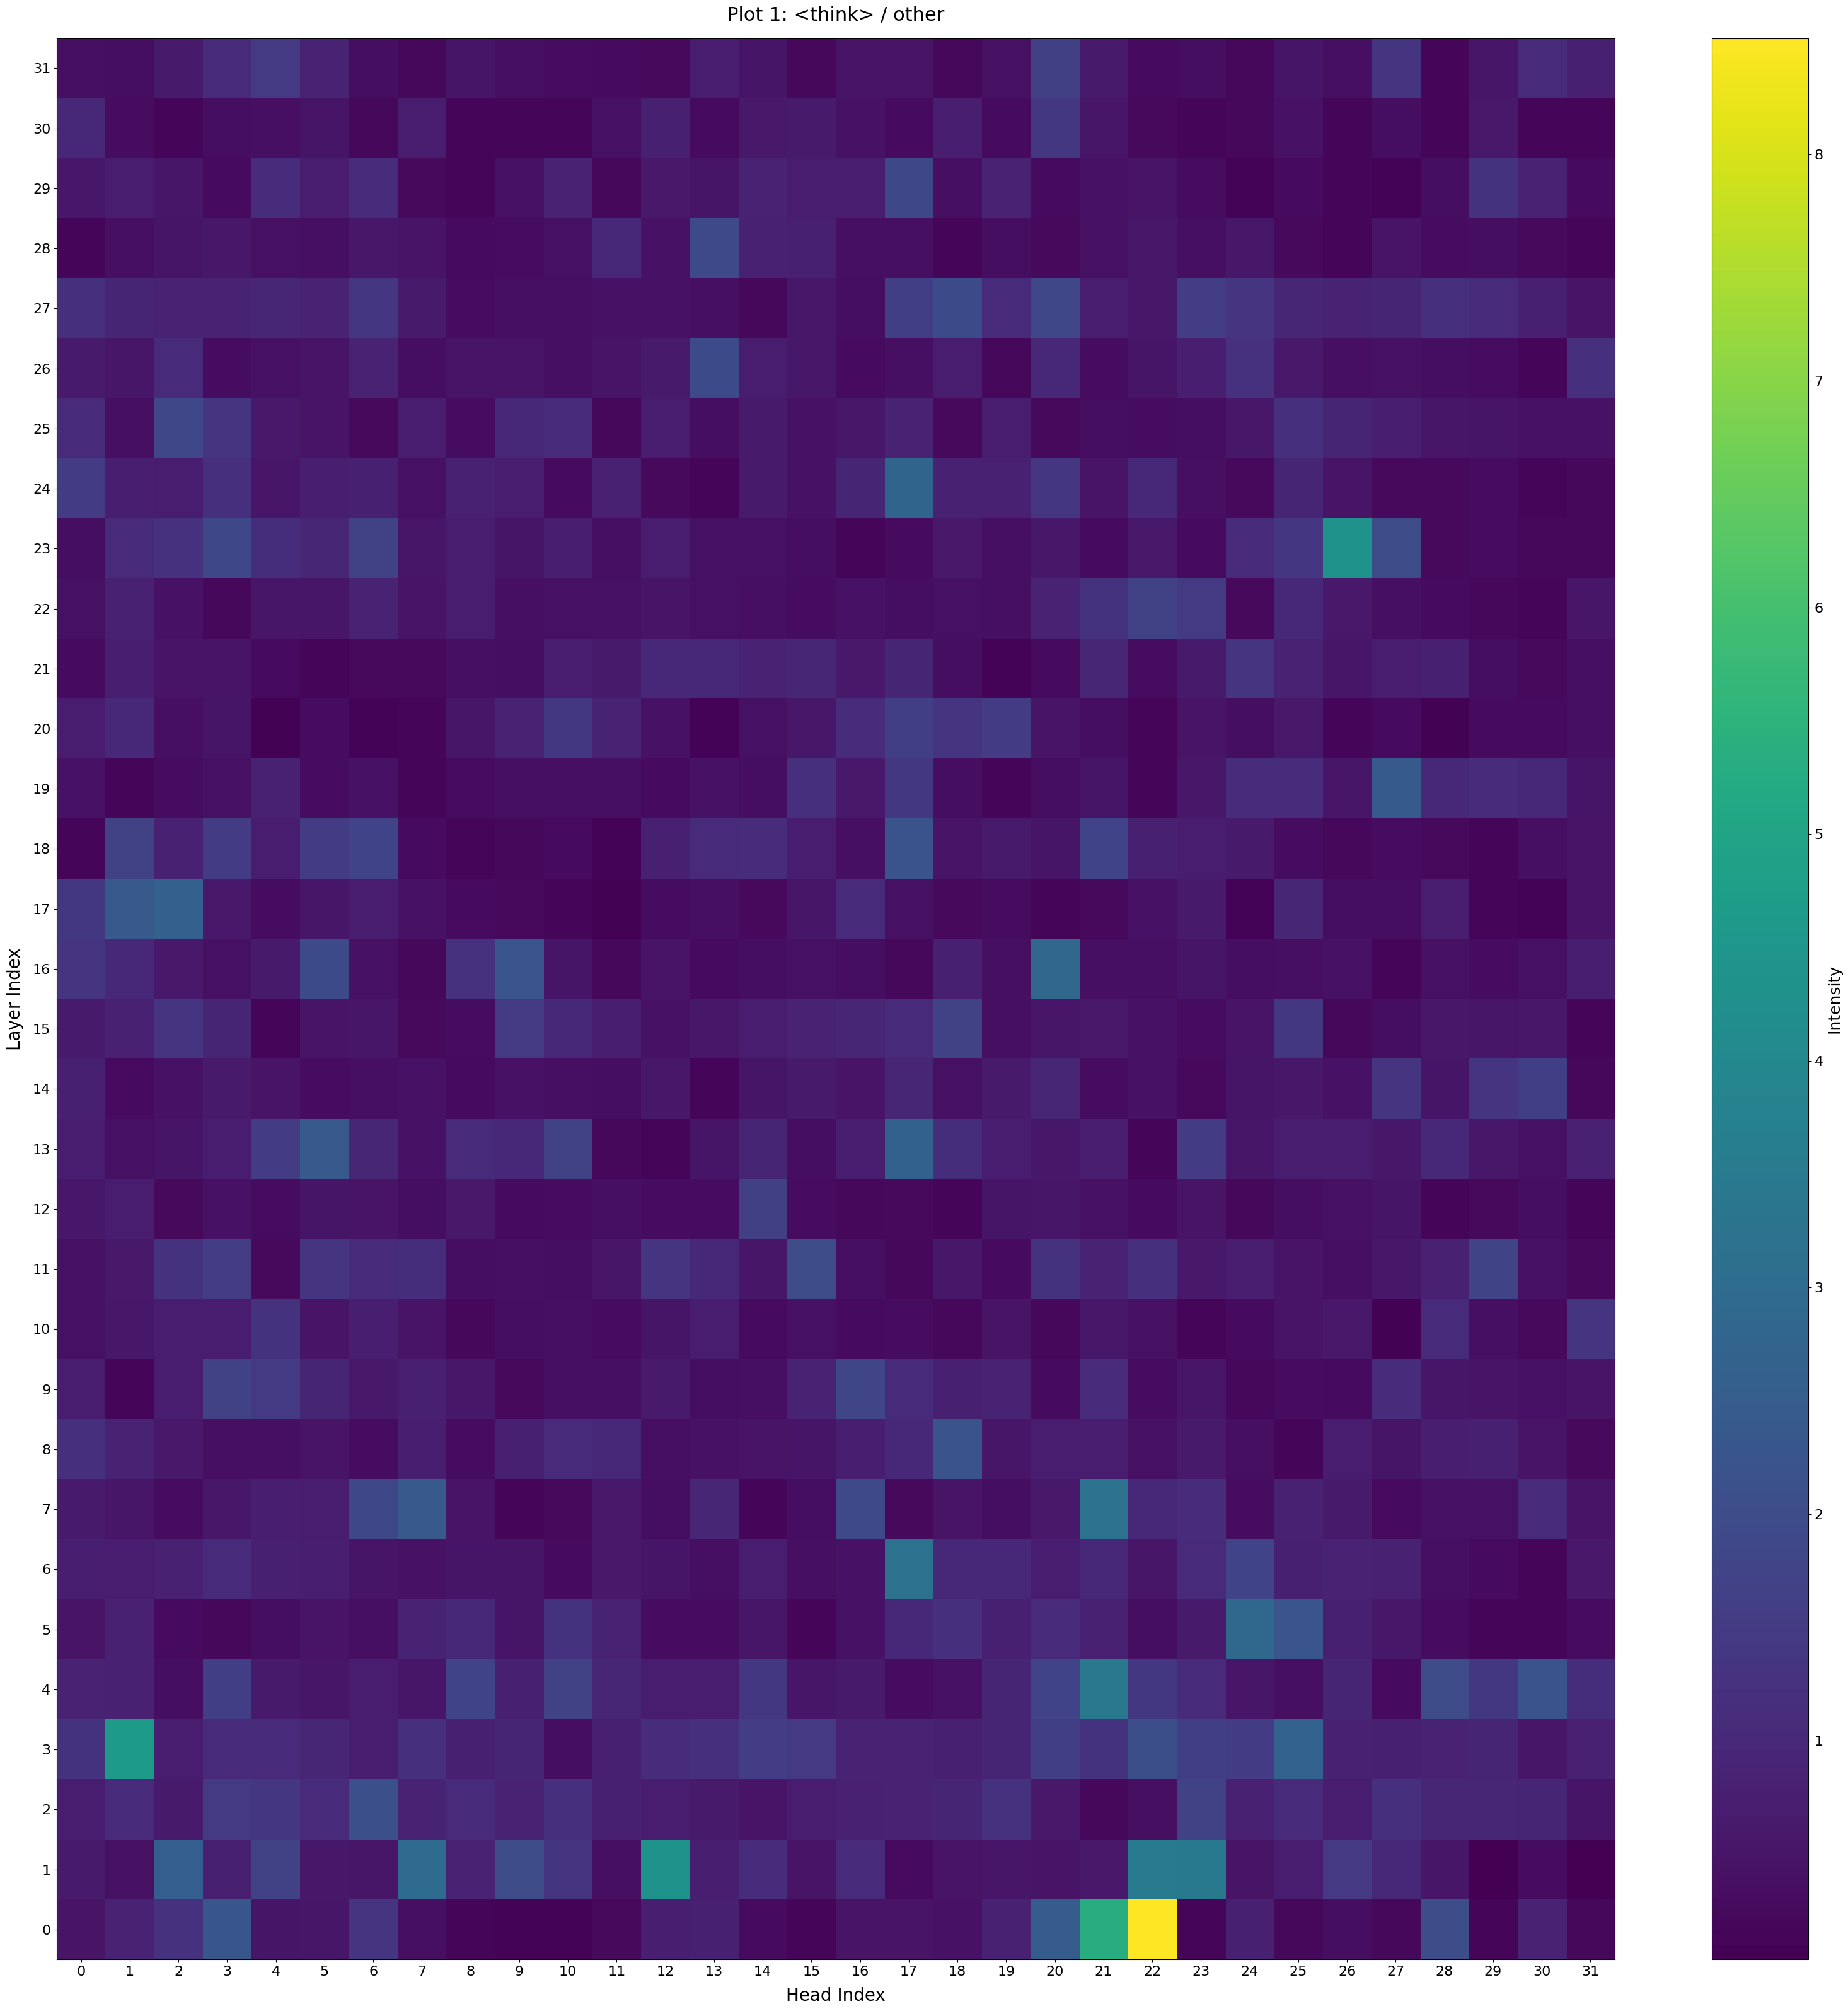

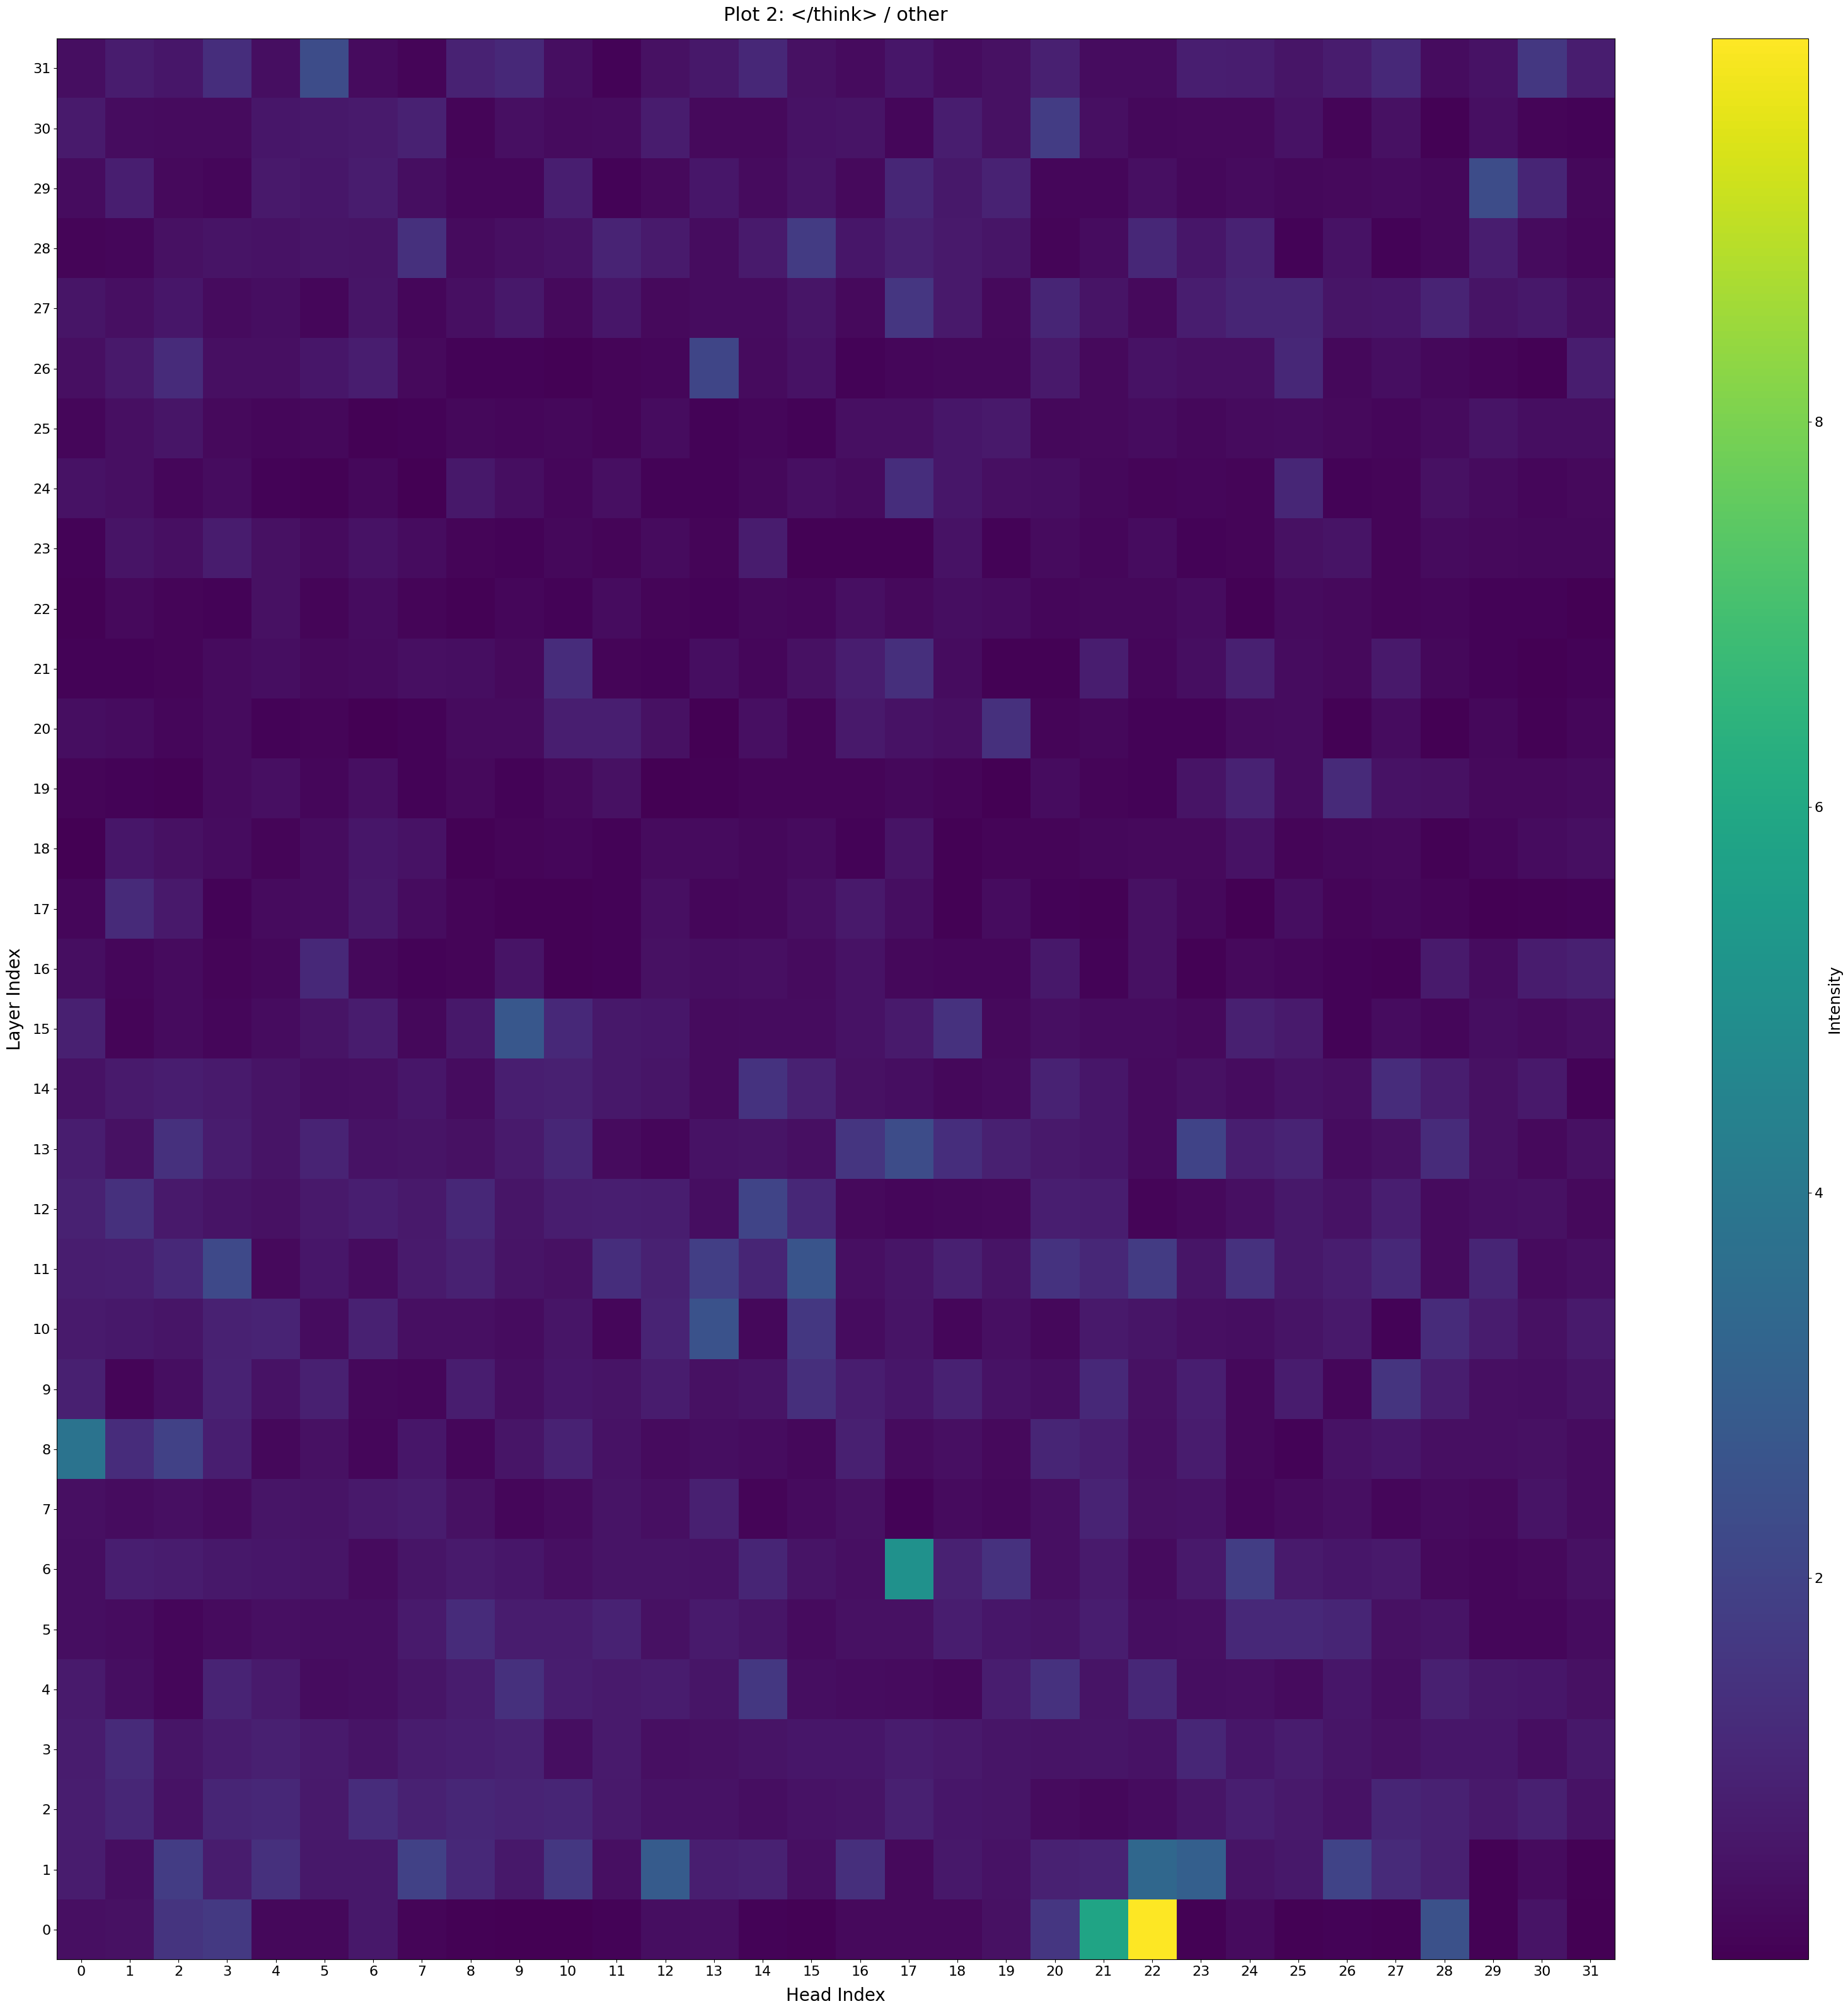

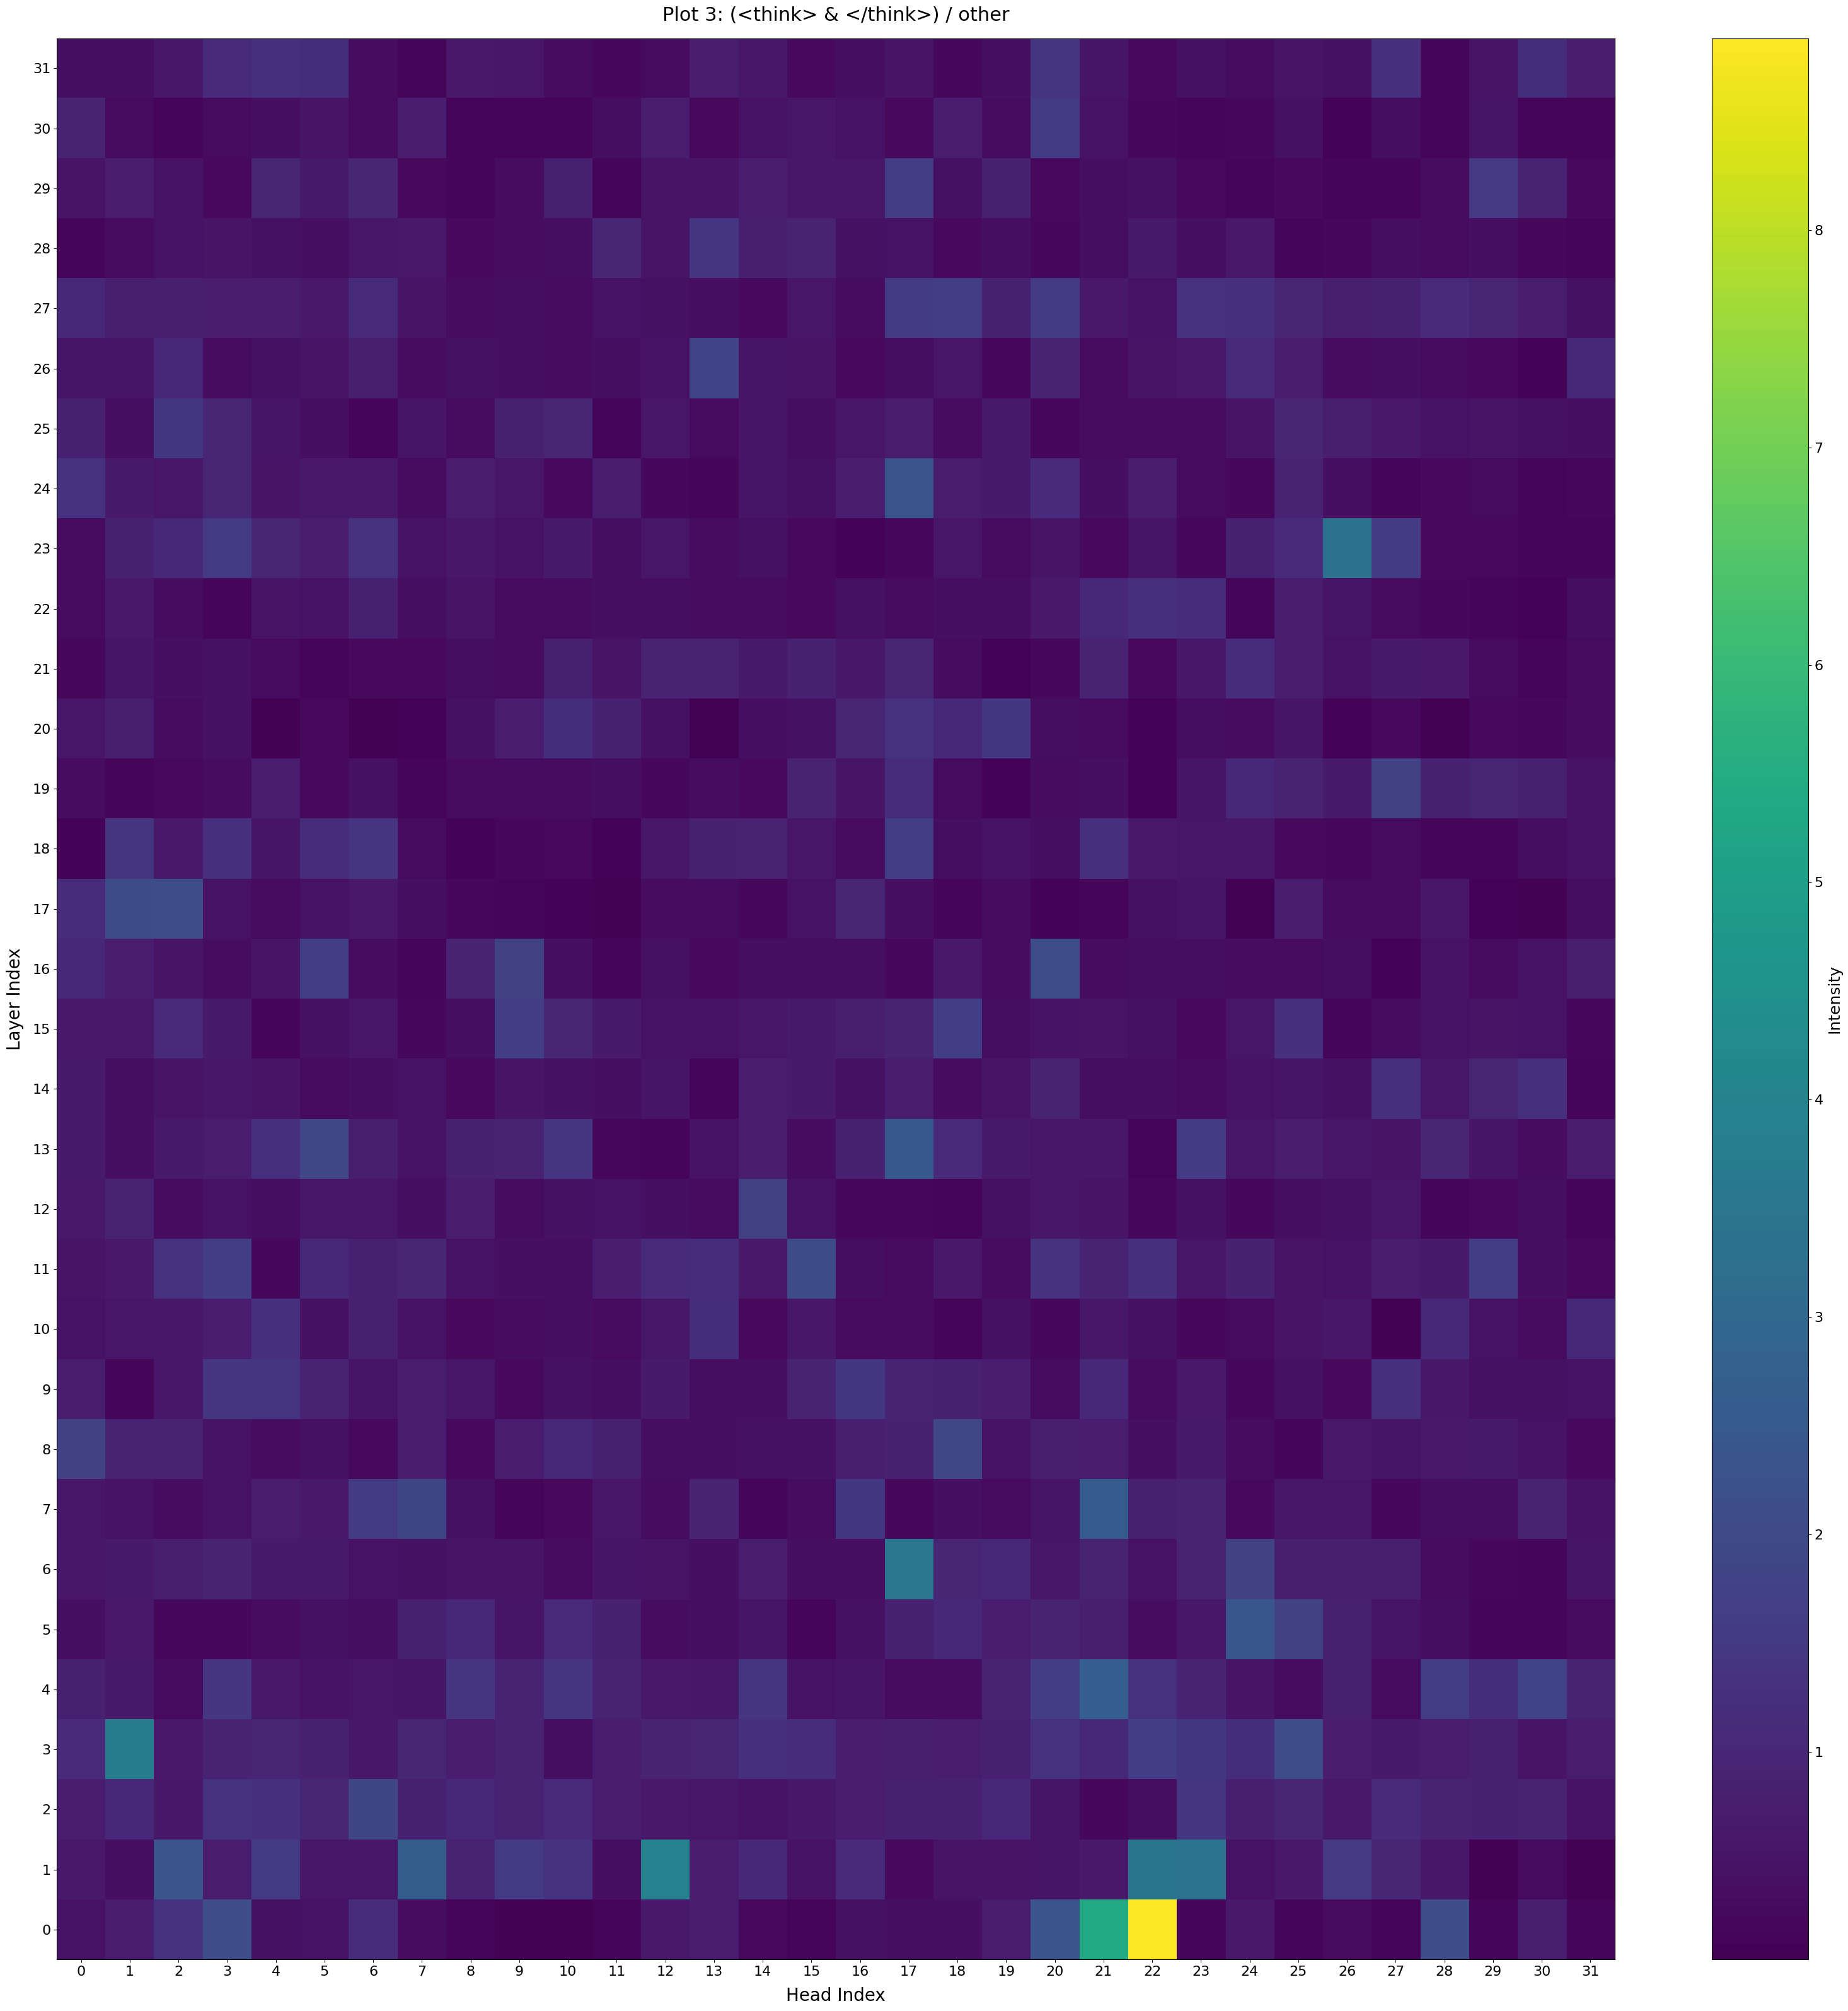

In [27]:
plot_ratios(collected_dict)

In [5]:
# importing from my own code 
from activation_transplanting import *
from analysis_tools import *

In [6]:
# read the api_key
CONFIG.set_default_api_key(os.environ.get('NDIF_KEY'))

# read the hf token
os.environ['HF_TOKEN'] = os.environ.get('HF_TOKEN')

In [7]:
NDIF_models = [
    "meta-llama/Meta-Llama-3.1-405B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B",
    "meta-llama/Meta-Llama-3.1-70B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
] 

# inexaustive list
non_NDIF_models = [
    "meta-llama/Meta-Llama-3.1-8B",
]

In [8]:
# choose a model 
llama_model_string = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# remote = use NDIF
remote = True 

if remote and (llama_model_string not in NDIF_models):
    remote = False 
    print("Model not available on NDIF")

# load a model
llama = LanguageModel(llama_model_string)

# commented out for now
tk = LLamaExamineToolkit(
    llama_model=llama, 
    remote=True, 
)

In [9]:
def map_prompt_to_file_string(string):
    assert "<｜User｜>" in string
    simplified_string = string.replace("<｜User｜>", "").replace("<｜Assistant｜>", "").replace("\\", "").lower()
    
    def is_allowed(char):
        return (ord('a')<=ord(char)<=ord('z')) or (ord('0')<=ord(char)<=ord('9'))
    
    hashed = hash_string(string)

    return ''.join([c if is_allowed(c) else '_' for c in simplified_string]).replace("__", "")+str(hashed)

In [12]:
"""
Reasoning Prompts Reader

This script reads a list of reasoning prompts from a text file and creates a Python list.
The prompts are categorized into math, English, world history, and science questions.
"""

def read_prompts(file_path="reasoning-prompts.md"):
    """
    Read prompts from a text file and return them as a list of strings.
    
    Args:
        file_path (str): Path to the file containing reasoning prompts
        
    Returns:
        list: A list of strings, each containing a reasoning prompt
    """
    prompts = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Skip empty lines, headers, and category labels
                line = line.strip()
                if (line and 
                    not line.startswith('#') and 
                    not line.startswith('##') and
                    not line == ""):
                    
                    # Extract the prompt text by removing the number and period
                    parts = line.split('. ', 1)
                    if len(parts) > 1 and parts[0].isdigit():
                        prompt = parts[1]
                    else:
                        prompt = line
                        
                    prompts.append(prompt)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"Error reading prompts: {e}")
    
    return prompts

def get_prompts_by_category():
    """
    Get prompts organized by category
    
    Returns:
        dict: A dictionary with categories as keys and lists of prompts as values
    """
    all_prompts = read_prompts()
    
    # Define the prompt ranges for each category based on the numbering in the file
    categories = {
        "math": all_prompts[0:62],
        "english": all_prompts[62:124],
        "world_history": all_prompts[124:186],
        "science": all_prompts[186:250]
    }
    
    return categories

In [13]:
reasoning_string_list = read_prompts()


# procedure

Start out by collecting all the text generated in our previous runs 

In [14]:
with open('prompt_activity_cache.yaml', 'r') as file:
    prompt_cache = yaml.safe_load(file)

In [15]:
# collect strings 
precomputed_strings = []

for key in prompt_cache:
    ac = load_pickle(prompt_cache[key])
    # get the string from this
    cur_sentence = [None]*(len(ac.token_idx_to_value_dict)-1)
    assert ac.token_idx_to_value_dict[0] == ('<｜begin▁of▁sentence｜>', 128000)
    for i in ac.token_idx_to_value_dict:
        cur_sentence[i-1]=ac.token_idx_to_value_dict[i][0]
    
    assert not (None in cur_sentence)

    precomputed_strings.append(''.join(cur_sentence))



In [16]:
precomputed_strings

['<｜User｜>How many syllables are in the word "uncomfortable"?<｜Assistant｜><think>\nOkay, so I need to figure out how many syllables are in the word "uncomfortable." Hmm, I\'m not entirely sure about this, but I think I can break it down. Let me start by writing out the word: U-N-C-O-M-F-O-R-T-A-B-L-E. \n\nNow, syllables are usually groups of vowels and consonants that make up a part of a word. Each syllable typically has one vowel sound, but sometimes there can be more if the vowels are together. So, I\'ll go through the word letter by letter and try to split it into parts that make sense.\n\nStarting with "un", that\'s one syllable. It\'s like the "u" sound. Then, "com" could be another syllable. That\'s "k" and "o" making "com." So far, that\'s two syllables: un-com.\n\nNext, "fort" is another part. That\'s "f," "o," "r," "t." So that\'s three syllables: un-com-fort. Now, I\'m left with "-able." So, "able" would be another syllable, making it four. So, putting it all together: un-com

In [ ]:
#save_pickle(precomputed_strings, "precomputed_reasoning_strings.pkl")


Now for each string, and each head, compute the attention pattern 

We're interested in heads which attend stringly to `<think>` and `</think>` tokens 
as compared to other tokens 

Therefore we'll define a function which computes the average weights for 
 - <think>
 - </think>
 - other tokens 

we're looking for attention heads which attend strongly to these two former tokens

In [13]:
prompt_cache

{'how_many_syllables_are_in_the_worduncomfortable_think0e22629a0e3a8edb283c286dcc8295e818e2066747432e7c7ab22684b705c8a0': 'activity_container_pickles/how_many_syllables_are_in_the_worduncomfortable_think0e22629a0e3a8edb283c286dcc8295e818e2066747432e7c7ab22684b705c8a0.pkl',
 'identify_the_adverb_in_the_sentence_she_quickly_ran_to_the_store_thinkde6c47776a27eb39723c68d86b1a4ee81b996058c0bb8954d70f2f5dc0582e03': 'activity_container_pickles/identify_the_adverb_in_the_sentence_she_quickly_ran_to_the_store_thinkde6c47776a27eb39723c68d86b1a4ee81b996058c0bb8954d70f2f5dc0582e03.pkl',
 'identify_the_alliteration_in_peter_piper_picked_a_peck_of_pickled_peppers_think35995898f76ec5b0ea76f9611a305e99e46b36f6fee4b24d6b8fe8e1cc07d317': 'activity_container_pickles/identify_the_alliteration_in_peter_piper_picked_a_peck_of_pickled_peppers_think35995898f76ec5b0ea76f9611a305e99e46b36f6fee4b24d6b8fe8e1cc07d317.pkl',
 'identify_the_preposition_inthe_book_is_on_the_shelf_think5171bb444e115be8d9b57d35d0d5fa533

In [14]:
# extract attention pattern for each head 


In [15]:
def attention_analysis(
        attention_array: np.ndarray, 
        think_indices: list[int], 
        stop_think_indices: list[int], 
        other_indices: list[int]
    ):
    """
    Look in attention array and quantify the average think, stop think, and other attention values
    for each token, respecting causality.
    
    Args:
        attention_array: 2D array of shape [query_len, key_len] containing attention values
        think_indices: Indices of "think" tokens
        stop_think_indices: Indices of "stop think" tokens
        other_indices: Indices of "other" tokens
    
    Returns:
        tuple of average attention values (think, stop_think, other)
    """
    # Create causal mask (lower triangular matrix)
    causal_mask = np.tril(np.ones(attention_array.shape, dtype=bool))
    
    # Make a copy to avoid modifying the original
    attention_array = attention_array.copy()
    attention_array[~causal_mask] = -1  # Mask out non-causal attention values

    # Collect attention values for each token type
    average_think_value = attention_array[:, think_indices]
    average_think_value = average_think_value[average_think_value >= 0]

    average_stop_think_value = attention_array[:, stop_think_indices]
    average_stop_think_value = average_stop_think_value[average_stop_think_value >= 0]

    average_other_value = attention_array[:, other_indices]
    average_other_value = average_other_value[average_other_value >= 0]
    
    # Handle empty arrays when calculating means
    mean_think = np.mean(average_think_value) if len(average_think_value) > 0 else 0
    mean_stop_think = np.mean(average_stop_think_value) if len(average_stop_think_value) > 0 else 0
    mean_other = np.mean(average_other_value) if len(average_other_value) > 0 else 0
    
    return mean_think, mean_stop_think, mean_other

In [16]:
def analyze_attn_containers(llama, attn_containers):
    # extract activations for think 

    attn_analysis_results = dict()

    for container in attn_containers:
        cur_string = container.string

        token_ids = llama.tokenizer.encode(cur_string)
        token_labels = [llama.tokenizer.decode([tid]) for tid in token_ids]
        assert len(token_ids)==len(token_labels)

        start_think_indices = [i for i, v in enumerate(token_labels) if "<think>"==v]
        stop_think_indices = [i for i, v in enumerate(token_labels) if "</think>"==v]
        non_special_indices = [i for i, v in enumerate(token_ids) if v<128000]

        # Plot each layer and head
        for layer_idx in container.get_layers():
            # Full attention for this layer: shape [num_heads, seq_len, seq_len]
            layer_attention = container.get_attention(layer_idx)

            # Number of heads
            num_heads = layer_attention.shape[0]

            for head_idx in range(num_heads):
                # Extract attention for this head
                if isinstance(layer_attention, torch.Tensor):
                    head_attn = (
                        layer_attention[head_idx].float().detach().cpu().numpy()
                    )
                else:
                    head_attn = layer_attention[head_idx]
                
                head_tuple = (layer_idx, head_idx)

                t, st, o = attention_analysis(
                    attention_array=head_attn, 
                    think_indices=start_think_indices, 
                    stop_think_indices=stop_think_indices, 
                    other_indices=non_special_indices
                )

                if head_tuple not in attn_analysis_results:
                    attn_analysis_results[head_tuple] = {
                        '<think>':[t],
                        '</think>':[st],
                        'other':[o],
                    }
                else:
                    attn_analysis_results[head_tuple]['<think>'].append(t)
                    attn_analysis_results[head_tuple]['</think>'].append(st)
                    attn_analysis_results[head_tuple]['other'].append(o)

    return attn_analysis_results

In [37]:
precomputed_strings

['<｜User｜>How many syllables are in the word "uncomfortable"?<｜Assistant｜><think>\nOkay, so I need to figure out how many syllables are in the word "uncomfortable." Hmm, I\'m not entirely sure about this, but I think I can break it down. Let me start by writing out the word: U-N-C-O-M-F-O-R-T-A-B-L-E. \n\nNow, syllables are usually groups of vowels and consonants that make up a part of a word. Each syllable typically has one vowel sound, but sometimes there can be more if the vowels are together. So, I\'ll go through the word letter by letter and try to split it into parts that make sense.\n\nStarting with "un", that\'s one syllable. It\'s like the "u" sound. Then, "com" could be another syllable. That\'s "k" and "o" making "com." So far, that\'s two syllables: un-com.\n\nNext, "fort" is another part. That\'s "f," "o," "r," "t." So that\'s three syllables: un-com-fort. Now, I\'m left with "-able." So, "able" would be another syllable, making it four. So, putting it all together: un-com

In [17]:
def give_attention_for_each_head(llama, strings):
    letk = LLamaExamineToolkit(llama, remote=True, verbose=False)
    attn_containers = letk.produce_attention_distributions(strings=strings)
    return analyze_attn_containers(llama, attn_containers)

In [18]:
for i in range(50):
    attn_analysis_results = give_attention_for_each_head(llama, precomputed_strings[i:i+1])
    save_pickle(obj=attn_analysis_results, filepath=f"attn_analysis_results_{i}.pkl")

2025-04-09 19:41:23,437 ed03b20c-110c-43c7-8bef-0f9e37a4d689 - RECEIVED: Your job has been received and is waiting approval.
2025-04-09 19:41:23,858 ed03b20c-110c-43c7-8bef-0f9e37a4d689 - APPROVED: Your job was approved and is waiting to be run.
2025-04-09 19:41:24,358 ed03b20c-110c-43c7-8bef-0f9e37a4d689 - RUNNING: Your job has started running.
2025-04-09 19:41:30,260 ed03b20c-110c-43c7-8bef-0f9e37a4d689 - COMPLETED: Your job has been completed.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-04-09 19:41:50,281 76623a5c-de08-41b9-9710-a93ecf31fde1 - RECEIVED: Your job has been received and is waiting approval.
2025-04-09 19:41:50,849 76623a5c-de08-41b9-9710-a93ecf31fde1 - APPROVED: Your job was approved and i

In [28]:
import glob
attn_results = glob.glob("attn_analysis_results_*.pkl")

collected_attn_results = load_pickle(attn_results[0])

for i in range(1, len(attn_results)):
    attn = load_pickle(attn_results[i])
    for k1 in collected_attn_results:
        for k2 in collected_attn_results[k1]:
            collected_attn_results[k1][k2]+=attn[k1][k2]

In [31]:
for head_key in collected_attn_results:
    for string_key in collected_attn_results[head_key]:
        collected_attn_results[head_key][string_key] = np.mean(
            collected_attn_results[head_key][string_key]
        )

In [32]:
collected_attn_results

{(0, 0): {'<think>': np.float32(0.002712838),
  '</think>': np.float64(0.0014960111995391985),
  'other': np.float32(0.0062891226)},
 (0, 1): {'<think>': np.float32(0.0044740126),
  '</think>': np.float64(0.0014771267579978004),
  'other': np.float32(0.005014761)},
 (0, 2): {'<think>': np.float32(0.0069626714),
  '</think>': np.float64(0.004915304901991405),
  'other': np.float32(0.006229578)},
 (0, 3): {'<think>': np.float32(0.008663359),
  '</think>': np.float64(0.0034103604745777216),
  'other': np.float32(0.0032951154)},
 (0, 4): {'<think>': np.float32(0.0022753885),
  '</think>': np.float64(0.0005121841266586938),
  'other': np.float32(0.0035590332)},
 (0, 5): {'<think>': np.float32(0.0026542319),
  '</think>': np.float64(0.0005962631309076267),
  'other': np.float32(0.0036831168)},
 (0, 6): {'<think>': np.float32(0.0056680003),
  '</think>': np.float64(0.0014453232790544337),
  'other': np.float32(0.003643093)},
 (0, 7): {'<think>': np.float32(0.0020130118),
  '</think>': np.floa

In [184]:

def plot_ratios(data_dict):
    layers = sorted({layer for (layer, head) in data_dict.keys()})
    heads = sorted({head for (layer, head) in data_dict.keys()})
    num_layers = len(layers)
    num_heads = len(heads)
    
    layer_to_index = {layer: i for i, layer in enumerate(layers)}
    head_to_index = {head: j for j, head in enumerate(heads)}
    
    ratio_think_over_other = np.full((num_layers, num_heads), np.nan)
    ratio_endthink_over_other = np.full((num_layers, num_heads), np.nan)
    ratio_think_over_endthink = np.full((num_layers, num_heads), np.nan)
    
    for (layer, head), sub_dict in data_dict.items():
        i = layer_to_index[layer]
        j = head_to_index[head]
        try:
            val_think = sub_dict['<think>']
            val_endthink = sub_dict['</think>']
            val_other = sub_dict['other']
            
            ratio_think_over_other[i, j] = val_think / val_other
            ratio_endthink_over_other[i, j] = val_endthink / val_other
            ratio_think_over_endthink[i, j] = (val_think + val_endthink)/val_other
        except KeyError:
            continue

    def plot_matrix(matrix, title):
        plt.figure(figsize=(num_heads, num_layers))
        im = plt.imshow(matrix, origin='lower', aspect='auto', interpolation='none')
        cbar = plt.colorbar(im)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label('Intensity', fontsize=18)
        
        plt.title(title, fontsize=22, pad=20)
        plt.xlabel('Head Index', fontsize=20, labelpad=10)
        plt.ylabel('Layer Index', fontsize=20, labelpad=10)
        
        plt.xticks(ticks=range(num_heads), labels=heads, fontsize=16)
        plt.yticks(ticks=range(num_layers), labels=layers, fontsize=16)
        
        plt.tight_layout()
        plt.show()

    plot_matrix(ratio_think_over_other, "Plot 1: <think> / other")
    plot_matrix(ratio_endthink_over_other, "Plot 2: </think> / other")
    plot_matrix(ratio_think_over_endthink, "Plot 3: (<think> + </think>) / other")


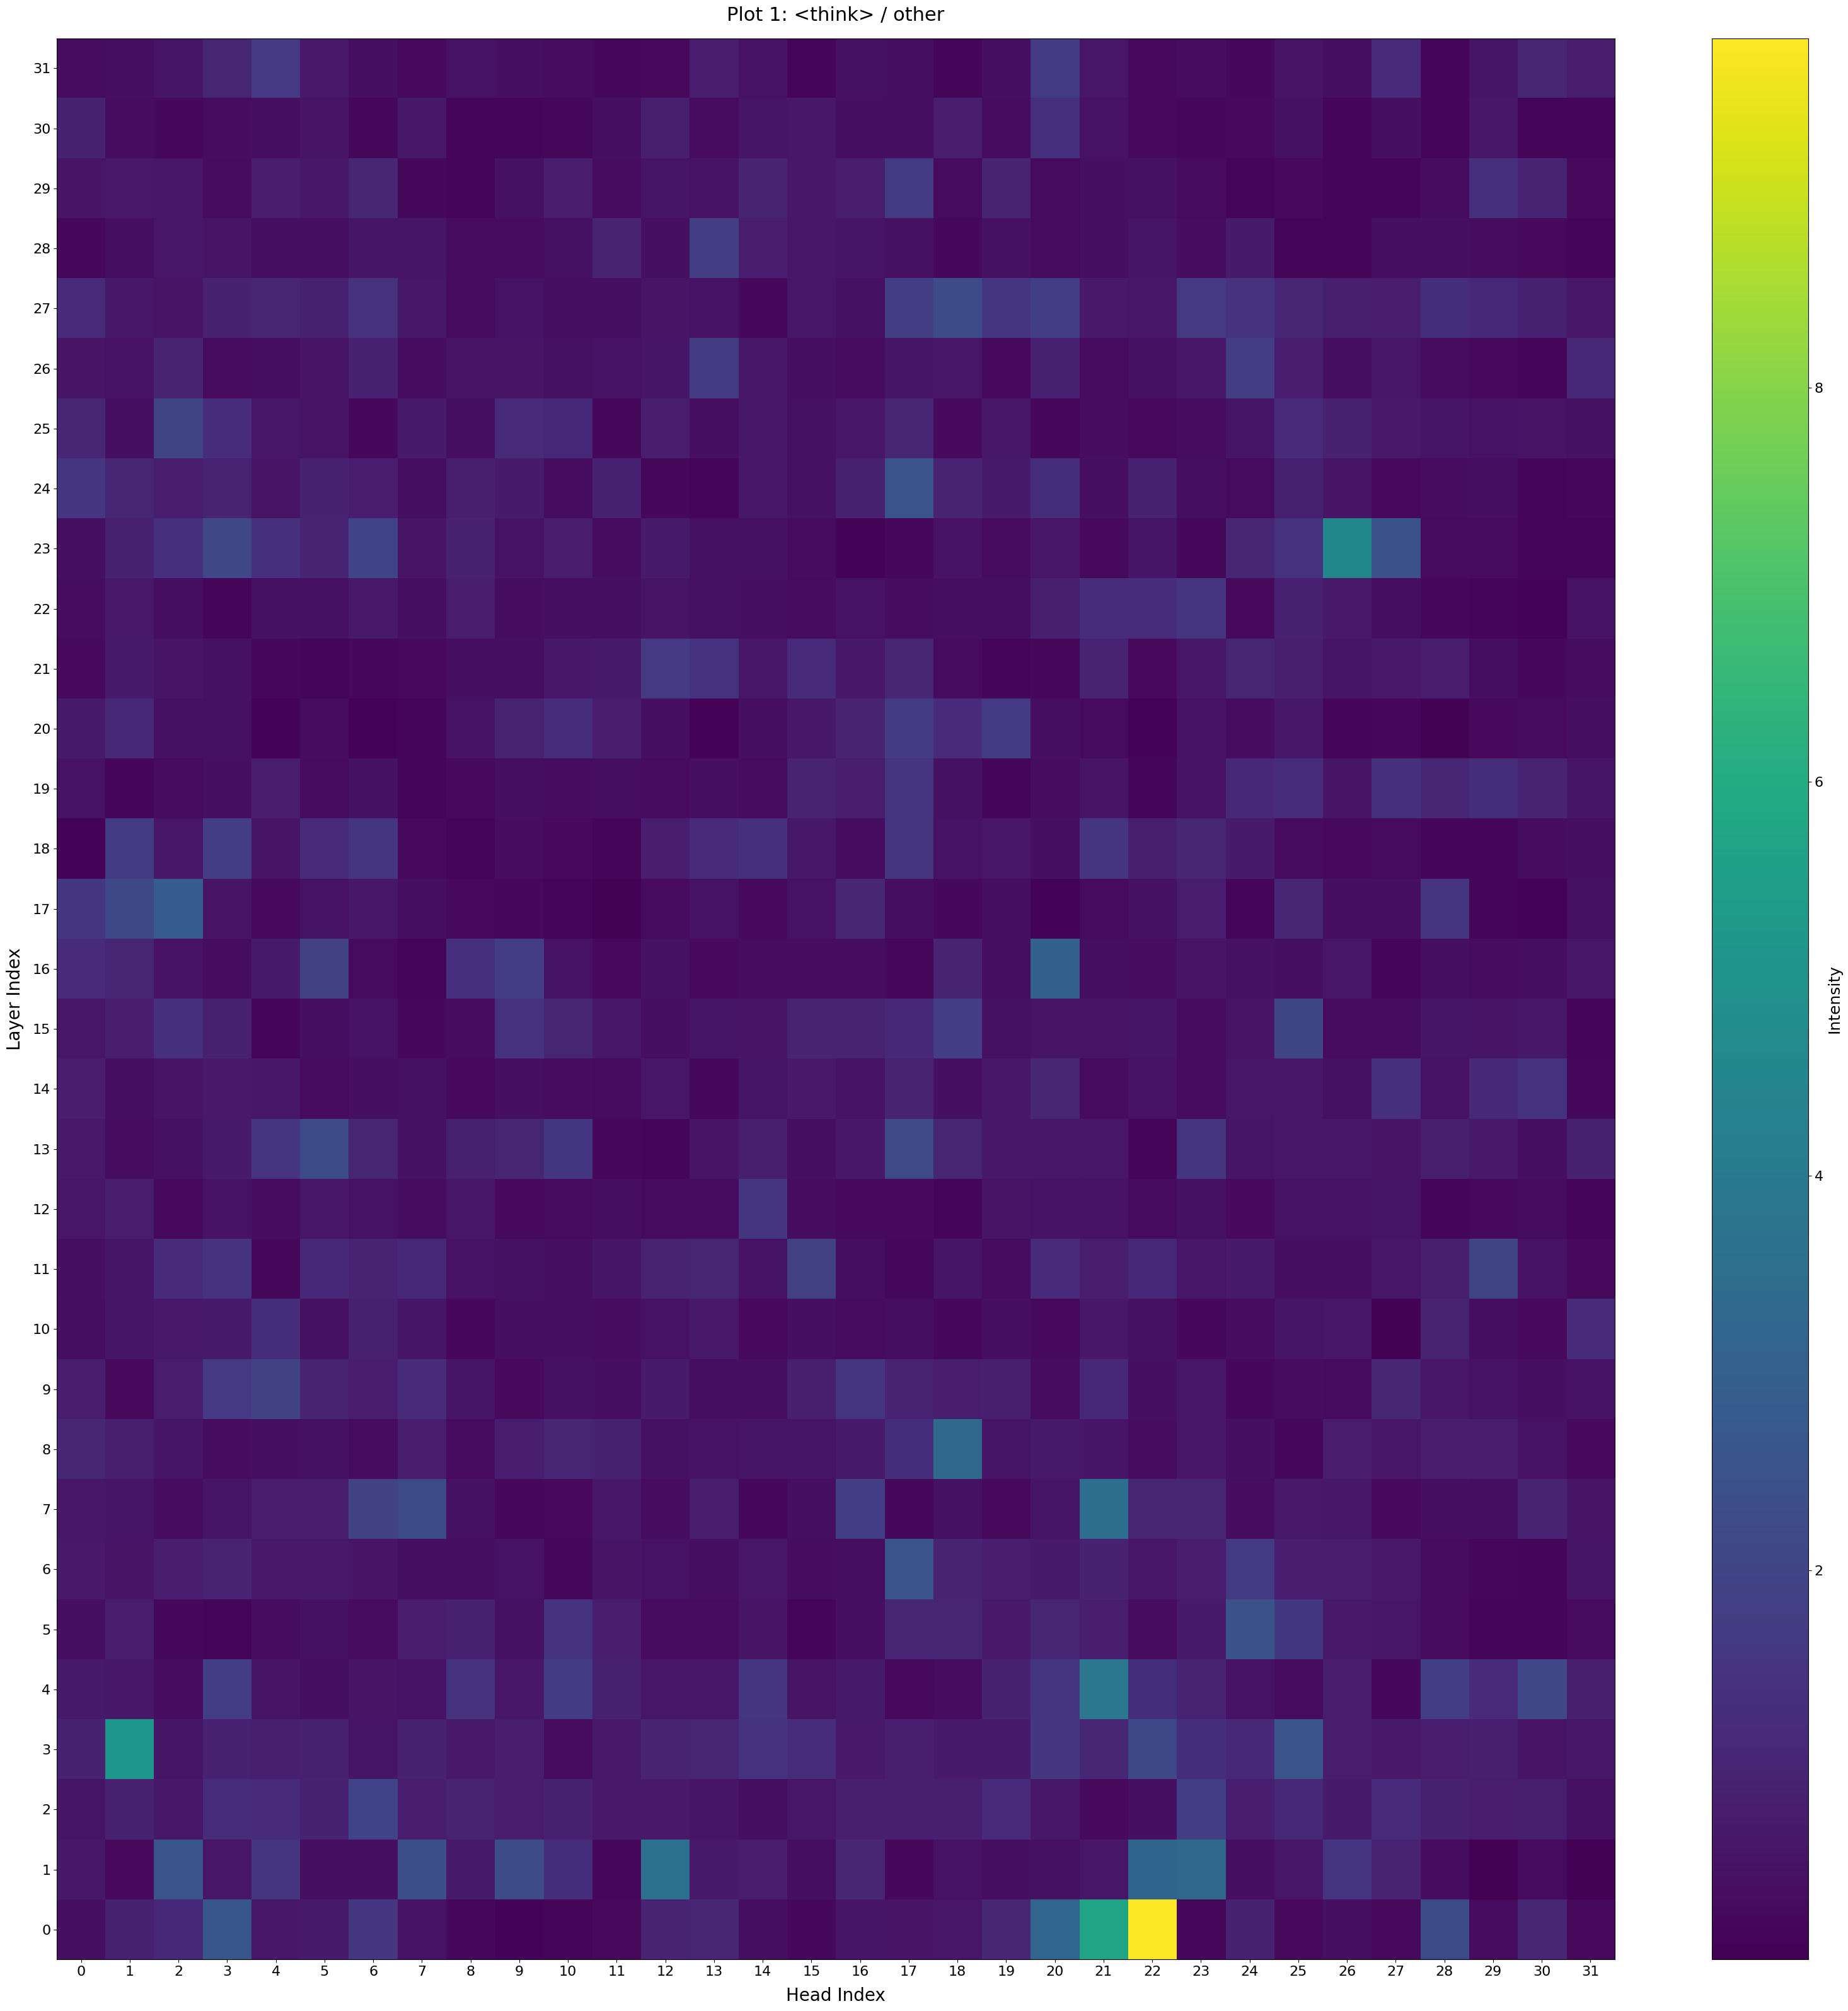

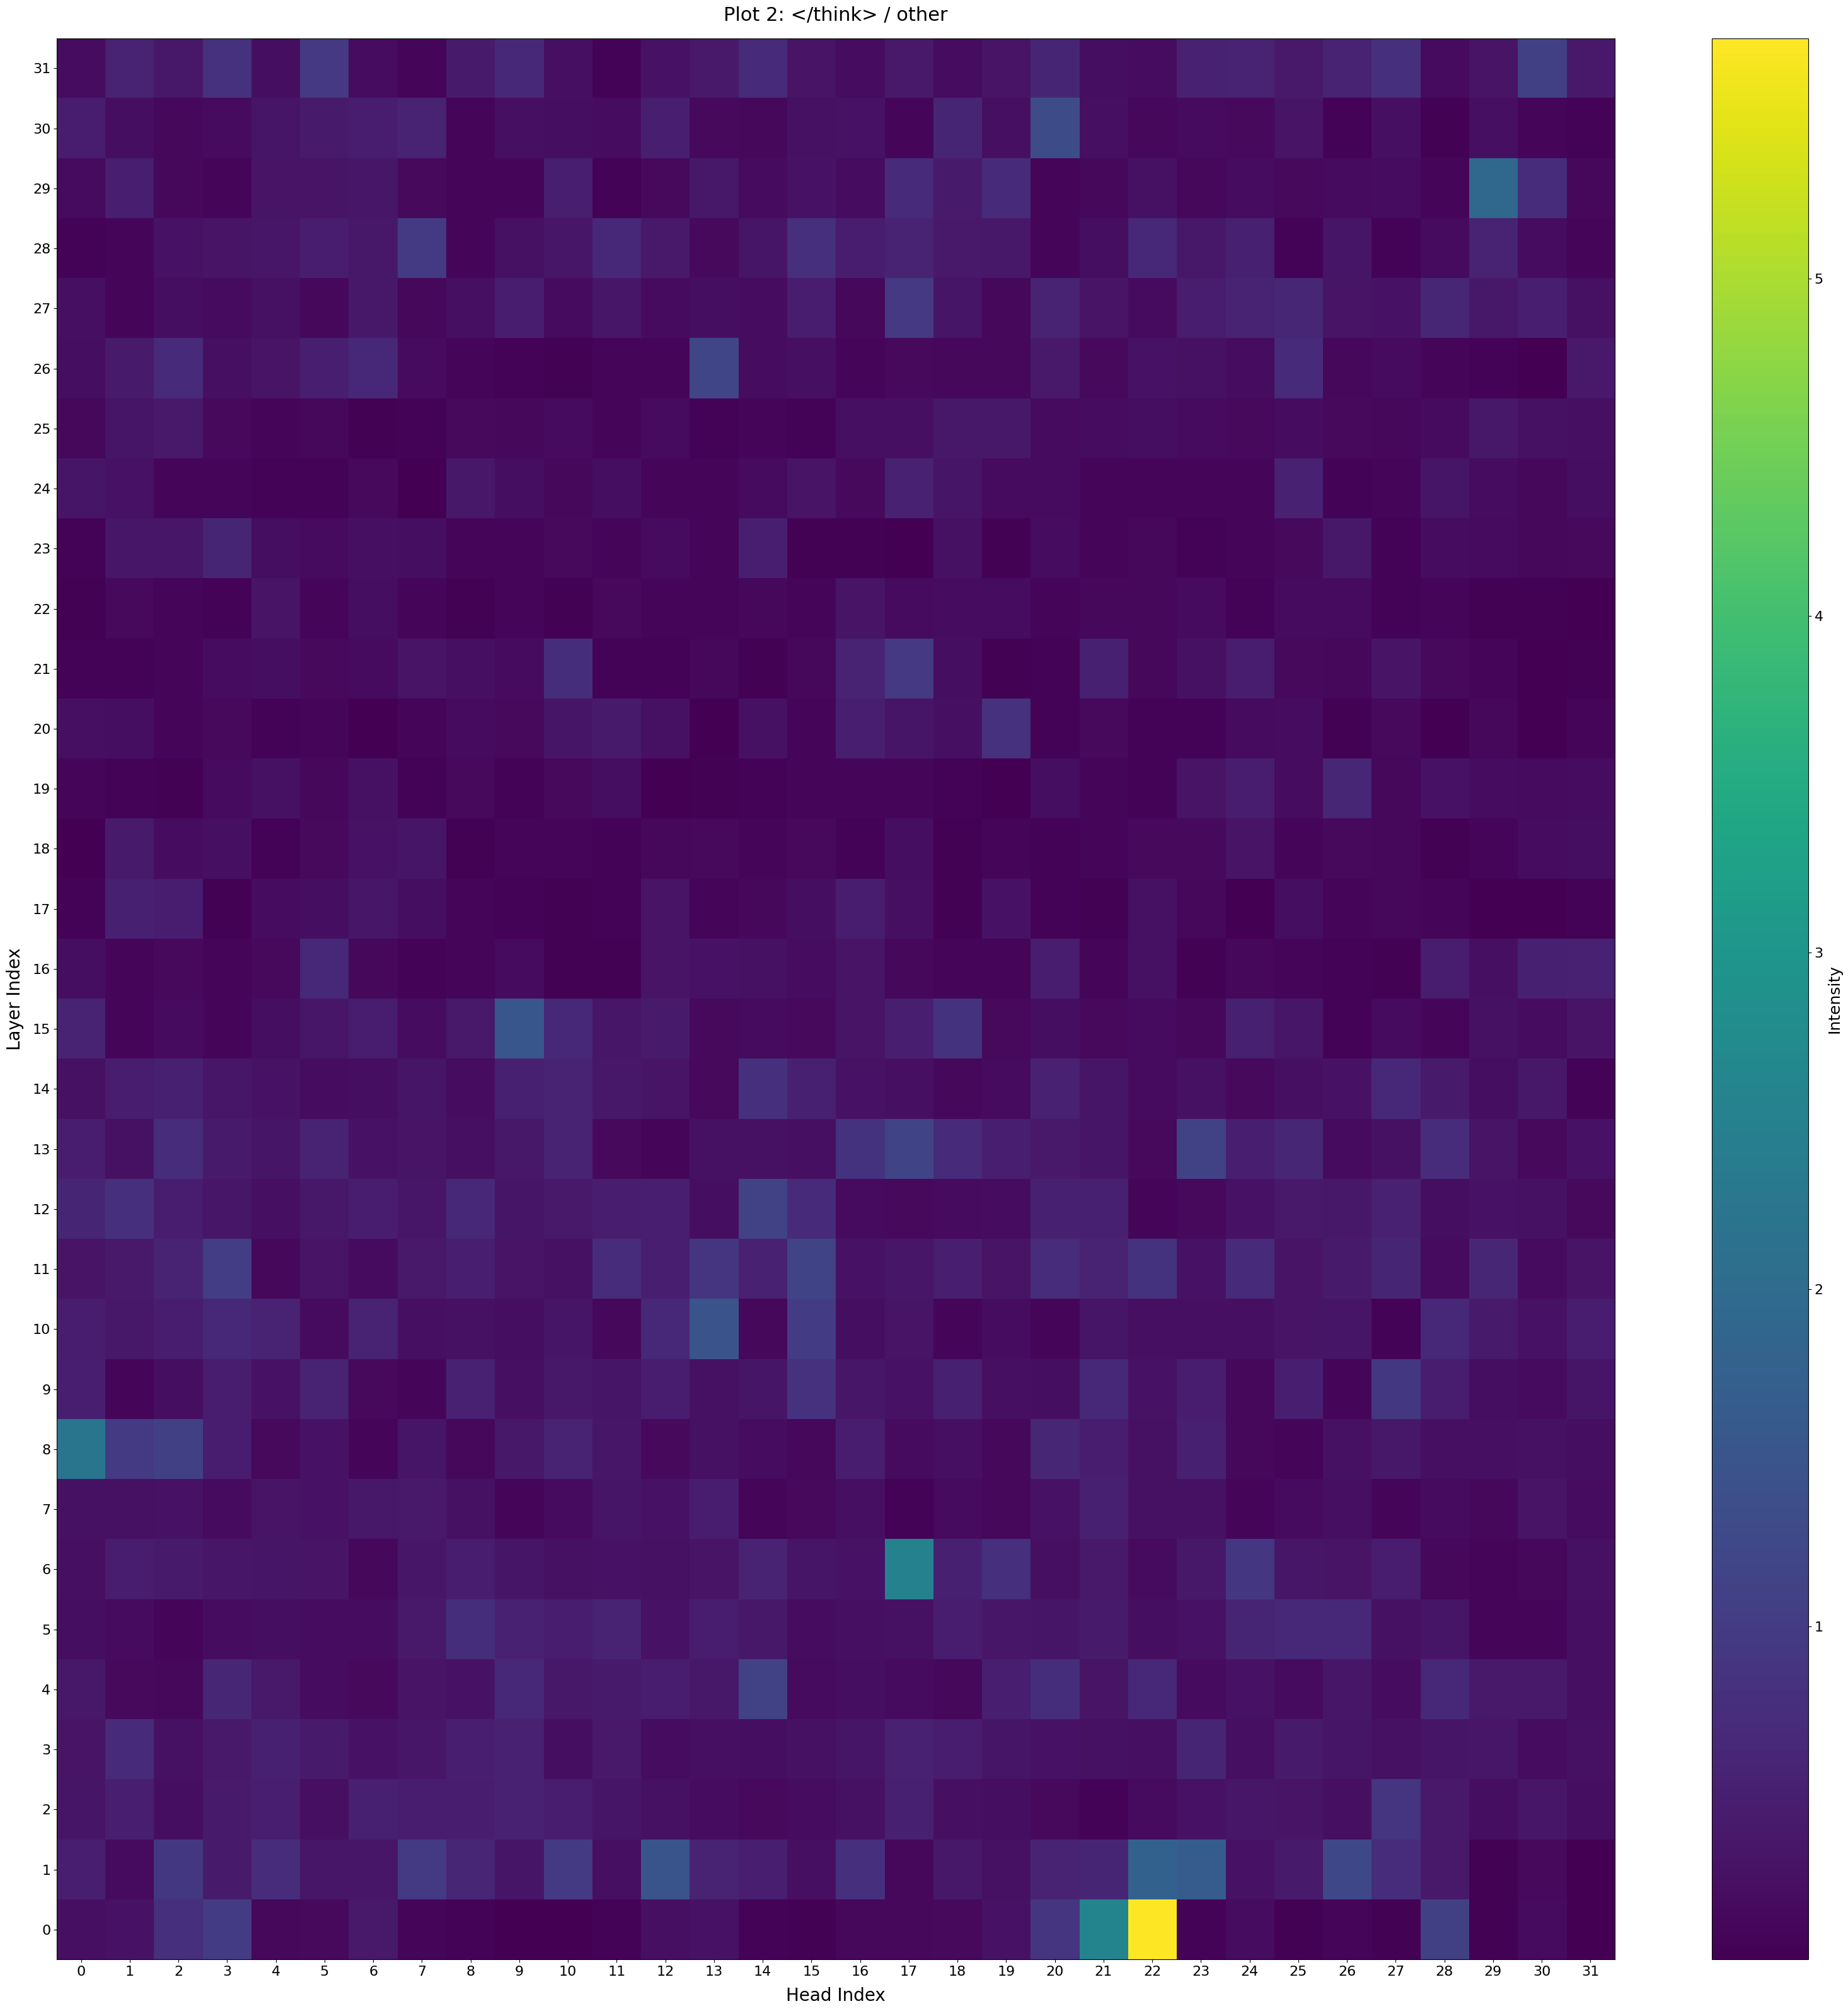

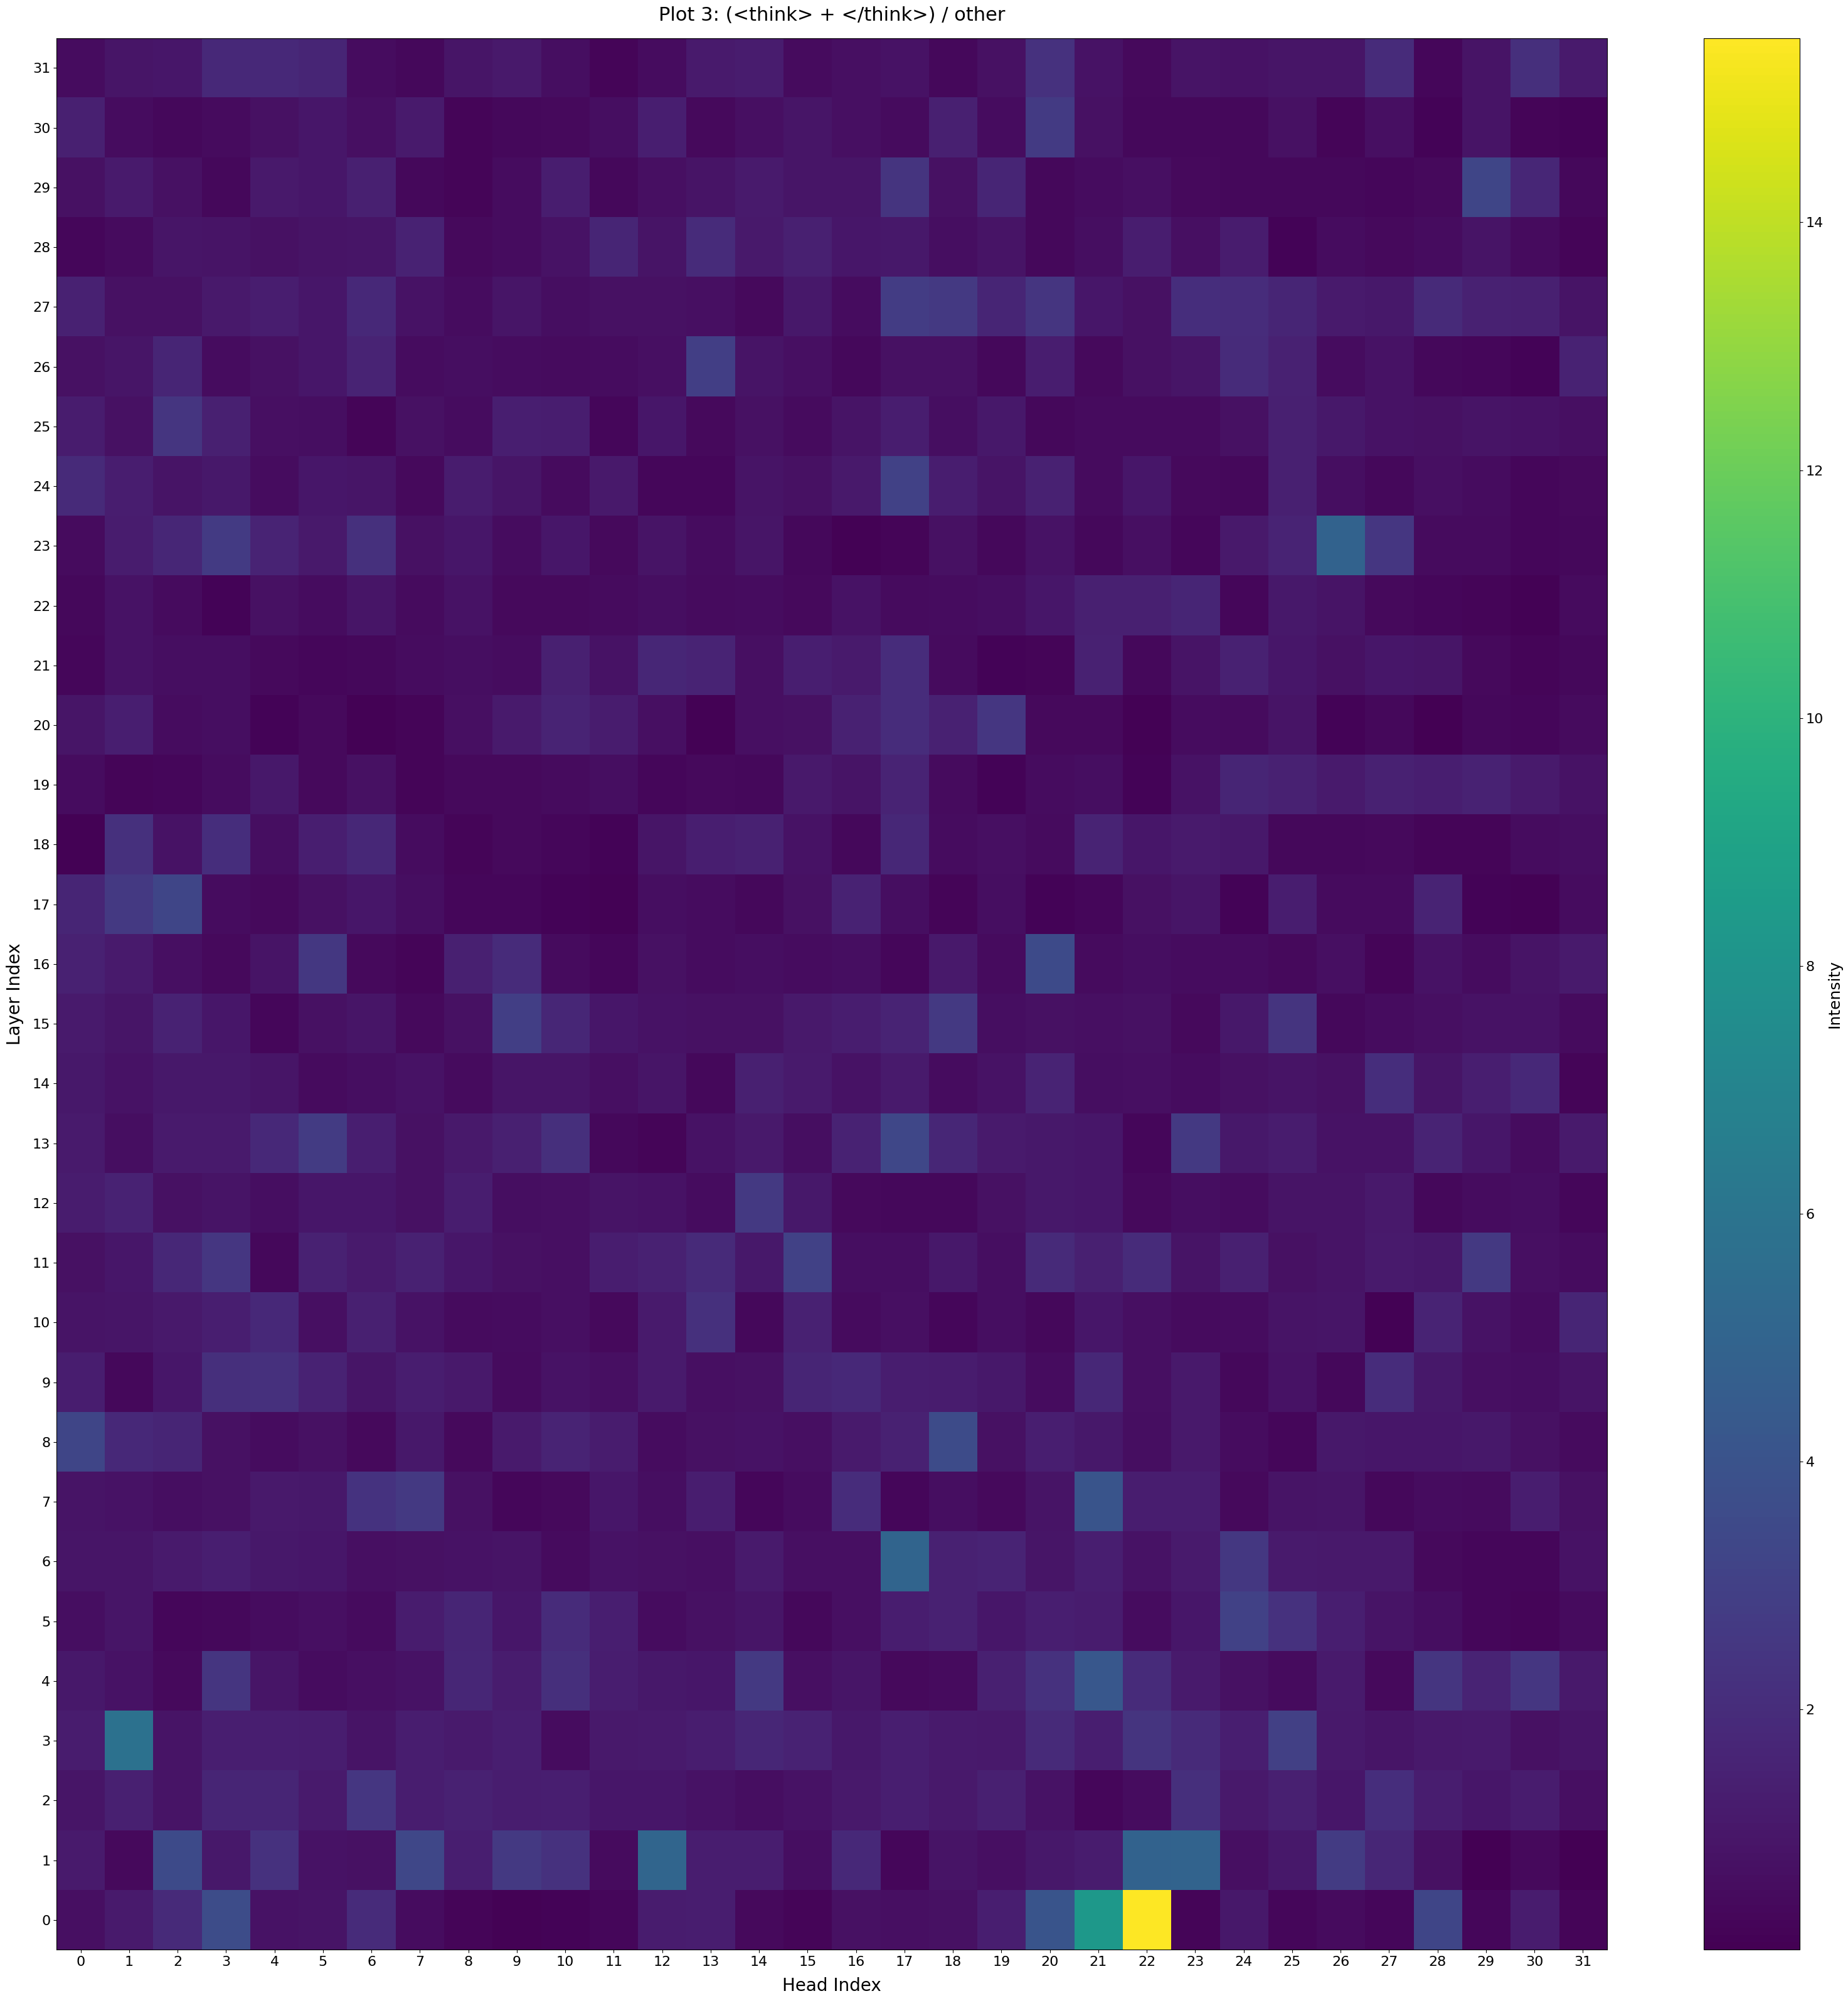

In [185]:
plot_ratios(collected_attn_results)

In [177]:
def get_head_OV(llama, v_proj_weights, o_proj_weights, query_head_idx):
    """
    Returns the effective OV (value then output projection) matrix for a given query head index,
    for a Llama model using grouped attention.
    
    Args:
        llama: The model (or an object with .config) that has the following attributes:
               - llama.config.num_attention_heads: total number of query heads (e.g., 32)
               - llama.config.num_key_value_heads: total number of key/value heads (e.g., 8)
               - llama.config.head_dim: dimension per head (e.g., 128)
        v_proj_weights (torch.Tensor): Weight matrix from the value projection layer.
                                       Expected shape: (num_key_value_heads * head_dim, hidden_dim)
        o_proj_weights (torch.Tensor): Weight matrix from the output projection layer.
                                       Expected shape: (hidden_dim, num_attention_heads * head_dim)
        query_head_idx (int): The index of the query head for which to compute the effective OV matrix.
    
    Returns:
        torch.Tensor: The effective combined OV matrix that maps input x (of shape (..., hidden_dim))
                      directly to the head’s contribution (of shape (..., hidden_dim)).
                      This matrix has shape (hidden_dim, hidden_dim).
    """
    # Extract configuration parameters.
    num_query_heads = llama.config.num_attention_heads    # e.g., 32
    num_key_value_heads = llama.config.num_key_value_heads   # e.g., 8
    head_dim = llama.config.head_dim                         # e.g., 128

    # In grouped attention, several query heads share one key/value head.
    multiplier = num_query_heads // num_key_value_heads      # e.g., 32 // 8 = 4

    # Map the given query head index to its corresponding key/value head index.
    key_head_idx = query_head_idx // multiplier              # e.g., query_head_idx=17 -> key_head_idx=4

    # --- Extract the relevant slice from the v_proj weights ---
    # v_proj_weights has shape (num_key_value_heads * head_dim, hidden_dim)
    # We need the slice corresponding to key_head_idx.
    start_v = key_head_idx * head_dim
    end_v = (key_head_idx + 1) * head_dim
    W_v_i = v_proj_weights[start_v:end_v, :]  # shape: (head_dim, hidden_dim)

    # --- Extract the relevant slice from the o_proj weights ---
    # o_proj_weights has shape (hidden_dim, num_query_heads * head_dim)
    # We need the slice corresponding to the query head.
    start_o = query_head_idx * head_dim
    end_o = (query_head_idx + 1) * head_dim
    W_o_j = o_proj_weights[:, start_o:end_o]  # shape: (hidden_dim, head_dim)

    # --- Combine the two slices into an effective OV matrix ---
    # When x is passed in, the operations would be:
    # v_slice = x @ (W_v_i)^T        [since v_proj is Linear with weights of shape (out, in)]
    # output   = v_slice @ (W_o_j)^T  [since o_proj is Linear with weights of shape (out, in)]
    # So the combined effective operation is:
    # output = x @ (W_v_i^T @ W_o_j^T)
    # Hence, the effective OV matrix is:
    effective_OV = W_v_i.T @ W_o_j.T  # shape: (hidden_dim, hidden_dim)
    return effective_OV

In [147]:
v_proj_weights = torch.load("v_projection_weights_layer_0.pt")
o_proj_weights = torch.load("o_projection_weights_layer_0.pt")

ov_mat_layeridx_0_headidx_22 = get_head_OV(llama, v_proj_weights, o_proj_weights, query_head_idx=22)

In [191]:
o_proj_weights.shape

torch.Size([4096, 4096])

In [149]:
ov_mat_layeridx_0_headidx_22.shape

torch.Size([4096, 4096])

# applying this to the think token

In [152]:
llama.tokenizer.encode("<think>")

[128000, 128013]

In [160]:
embeddings = torch.load("llama_embedding.pt")

In [155]:
ov_mat_layeridx_0_headidx_22.device

device(type='mps', index=0)

In [161]:
embeddings[128013]

tensor([-0.0029,  0.0013, -0.0004,  ...,  0.0022, -0.0009,  0.0005],
       device='mps:0', grad_fn=<SelectBackward0>)

In [162]:
think_output_0_22 = ov_mat_layeridx_0_headidx_22 @ embeddings[128013]

In [163]:
think_output_0_22

tensor([ 1.4749e-04,  8.7795e-06, -6.2106e-05,  ...,  1.4308e-04,
        -3.7241e-05, -2.1920e-04], device='mps:0', grad_fn=<MvBackward0>)

# What is the alignment of this with the observed residual vector?

In [168]:
think_output_numpy = think_output_0_22.cpu().detach().numpy() 

In [172]:
normed_think_output_numpy = think_output_numpy/np.sqrt(np.sum(think_output_numpy**2))

load the first layer's w vector

In [187]:
alignments = []

for i in range(1, 32):
    w_vector_layer_ = np.load(f"layer_{i}_analyses/Layer_{i}_analysis_w_vector.npy")
    alignments.append(
        np.sum(normed_think_output_numpy*w_vector_layer_)
    )

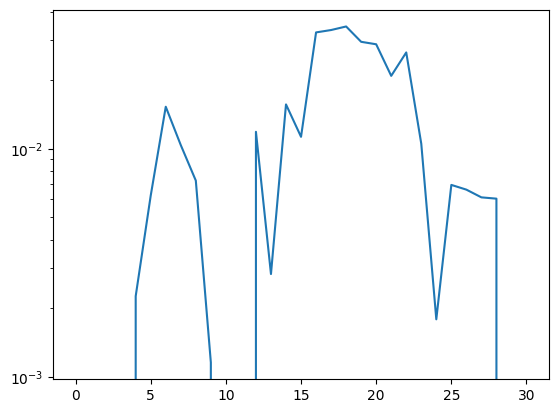

In [189]:
plt.plot(alignments)
plt.yscale('log')

In [182]:
w_vector_layer_20 = np.load("layer_20_analyses/Layer_20_analysis_w_vector.npy")

In [183]:
np.sum(normed_think_output_numpy*w_vector_layer_20)

np.float32(0.029523447)

In [51]:
llama.config

128

In [68]:
type(llama)

nnsight.modeling.language.LanguageModel

In [62]:
for v in llama.model.layers[0].self_attn.named_parameters():
    print(v[0])
    print(v[1])
    print("-----")

q_proj.weight
Parameter containing:
tensor(..., device='meta', size=(4096, 4096), dtype=torch.bfloat16,
       requires_grad=True)
-----
k_proj.weight
Parameter containing:
tensor(..., device='meta', size=(1024, 4096), dtype=torch.bfloat16,
       requires_grad=True)
-----
v_proj.weight
Parameter containing:
tensor(..., device='meta', size=(1024, 4096), dtype=torch.bfloat16,
       requires_grad=True)
-----
o_proj.weight
Parameter containing:
tensor(..., device='meta', size=(4096, 4096), dtype=torch.bfloat16,
       requires_grad=True)
-----


In [118]:
device_map_strategy = 'auto'
# device_map_strategy = 'cuda' # If you have one GPU and enough VRAM
# device_map_strategy = 'cpu' # If you only have CPU or low VRAM (will be slow)

print(f"Attempting to load model with device_map='{device_map_strategy}'...")

try:
    # Replace 'your-llama-model-identifier' with the actual model name
    # e.g., 'meta-llama/Llama-2-7b-hf'
    llama = LanguageModel(
        "deepseek-ai/DeepSeek-R1-Distill-Llama-8B", # <--- Make sure this is correct
        device_map=device_map_strategy
        # You might also need other args like auth tokens depending on the model
        # token='YOUR_HF_TOKEN' # If needed
    )
    print("Model loaded successfully.")

    # --- Verify device ---
    # Check the device of a parameter
    first_param_device = next(llama.model.parameters()).device
    print(f"Model parameters are on device: {first_param_device}")

    # --- Access the weights (should work now) ---
    if str(first_param_device) != 'meta':
        layer_index = 0
        v_weights = llama.model.layers[layer_index].self_attn.v_proj.weight
        o_weights = llama.model.layers[layer_index].self_attn.o_proj.weight

        print("\n--- V Projection Weights ---")
        print("Shape:", v_weights.shape)
        print("Device:", v_weights.device)
        # print(v_weights) # Print the actual tensor data (can be large)

        print("\n--- O Projection Weights ---")
        print("Shape:", o_weights.shape)
        print("Device:", o_weights.device)
        # print(o_weights) # Print the actual tensor data

    else:
        print("Model still loaded on 'meta' device. Check loading arguments.")

except Exception as e:
    print(f"Error loading model: {e}")
    # Common errors: Model identifier incorrect, missing auth token, out of memory.


Attempting to load model with device_map='auto'...
Model loaded successfully.
Model parameters are on device: meta
Model still loaded on 'meta' device. Check loading arguments.


In [38]:
collected_attn_results[(0, 22)]

{'<think>': np.float32(0.027710171),
 '</think>': np.float64(0.016200171929656292),
 'other': np.float32(0.002835356)}

Now lets try to extract the OV matrix for this head

as well as the embedding matrix 

what does it do to 

In [119]:
# choose a model 
llama_model_string = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# remote = use NDIF
remote = False

if remote and (llama_model_string not in NDIF_models):
    remote = False 
    print("Model not available on NDIF")

# load a model
llama_local = LanguageModel(llama_model_string)

In [120]:
llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [121]:
llama_local.model.layers

ModuleList(
  (0-31): 32 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
      (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
      (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
      (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
      (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
  )
)

In [122]:
attn_analysis_results

{(0, 0): {'<think>': [np.float32(0.0023120234)],
  '</think>': [0],
  'other': [np.float32(0.006174762)]},
 (0, 1): {'<think>': [np.float32(0.004458415)],
  '</think>': [0],
  'other': [np.float32(0.004675117)]},
 (0, 2): {'<think>': [np.float32(0.0058599706)],
  '</think>': [0],
  'other': [np.float32(0.0061078276)]},
 (0, 3): {'<think>': [np.float32(0.008780857)],
  '</think>': [0],
  'other': [np.float32(0.003292067)]},
 (0, 4): {'<think>': [np.float32(0.0024065797)],
  '</think>': [0],
  'other': [np.float32(0.0035139231)]},
 (0, 5): {'<think>': [np.float32(0.0028086563)],
  '</think>': [0],
  'other': [np.float32(0.0036009436)]},
 (0, 6): {'<think>': [np.float32(0.0055945516)],
  '</think>': [0],
  'other': [np.float32(0.0035319119)]},
 (0, 7): {'<think>': [np.float32(0.001980075)],
  '</think>': [0],
  'other': [np.float32(0.00418895)]},
 (0, 8): {'<think>': [np.float32(0.00093627686)],
  '</think>': [0],
  'other': [np.float32(0.0048305835)]},
 (0, 9): {'<think>': [np.float32(0.

In [123]:
import torch
from nnsight import LanguageModel

# Assuming 'llama' is your model loaded with device_map='auto'
# llama = LanguageModel('your-model-id', device_map='auto')

print("Checking devices of all parameters in llama.model...")
devices = set()
parameter_count = 0
if hasattr(llama, 'model') and hasattr(llama.model, 'parameters'):
    try:
        for param in llama.model.parameters():
            devices.add(str(param.device)) # Use str() to handle potential None or complex device objects
            parameter_count += 1
    except Exception as e:
        print(f"Error iterating parameters: {e}")

    print(f"Found {parameter_count} parameters.")
    print(f"Unique devices found across parameters: {devices}")

    if len(devices) == 1 and 'meta' in devices:
        print("All parameters seem to be on the 'meta' device.")
    elif len(devices) > 1:
        print("Parameters are distributed across multiple devices (or meta + other).")
    elif len(devices) == 1:
        print(f"All parameters seem to be on a single device: {list(devices)[0]}")
    else:
        print("No parameters found or devices could not be determined.")

else:
    print("Could not find llama.model or its parameters attribute.")

Checking devices of all parameters in llama.model...
Found 290 parameters.
Unique devices found across parameters: {'meta'}
All parameters seem to be on the 'meta' device.


In [76]:
layer_index=0

In [101]:
llama.model.embed_tokens.weight.shape

torch.Size([128256, 4096])

In [107]:
llama_local.tokenizer.encode("thi<think>")

[128000, 339, 72, 128013]

In [104]:
llama.tokenizer

PreTrainedTokenizerFast(name_or_path='meta-llama/Meta-Llama-3.1-8B', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>', 'pad_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128005: AddedToken("

In [108]:
llama_local.model.embed_tokens.weight

Parameter containing:
tensor(..., device='meta', size=(128256, 4096), dtype=torch.bfloat16,
       requires_grad=True)

In [158]:
llama.model.embed_tokens.weight

Parameter containing:
tensor([[-8.4686e-04,  9.4604e-03, -4.3640e-03,  ...,  4.9438e-03,
         -9.2316e-04,  4.9210e-04],
        [-1.9150e-03,  1.5640e-03, -8.8120e-04,  ...,  1.5793e-03,
         -2.8839e-03,  5.6458e-04],
        [ 4.9744e-03, -1.7334e-02,  3.7994e-03,  ...,  6.1340e-03,
          6.2866e-03,  6.5918e-03],
        ...,
        [ 2.2230e-23,  3.9291e-24,  2.1713e-23,  ...,  6.4106e-23,
         -2.6625e-24, -2.3678e-23],
        [ 2.2954e-23, -2.2230e-24, -2.2334e-23,  ...,  2.8124e-23,
          8.7371e-24, -3.7223e-23],
        [-8.8922e-23, -7.6101e-23,  6.5140e-24,  ...,  5.9195e-24,
         -6.4934e-23, -2.7271e-24]], device='mps:0', requires_grad=True)

In [159]:
torch.save(llama.model.embed_tokens.weight, "llama_embedding.pt")

In [109]:
llama=llama_local

In [124]:
# Access the module directly from the model
v_proj = llama_local.model.layers[layer_index].self_attn.v_proj
o_proj = llama.model.layers[layer_index].self_attn.o_proj

print("Trying .remote_parameter('weight') on the direct module...")
try:
    v_weights = v_proj.remote_parameter('weight')
    o_weights = o_proj.remote_parameter('weight')

    print("\n--- V Projection Weights (direct access) ---")
    print("Shape:", v_weights.shape)
    print("Device:", v_weights.device)

    print("\n--- O Projection Weights (direct access) ---")
    print("Shape:", o_weights.shape)
    print("Device:", o_weights.device)

except AttributeError:
    print("\n.remote_parameter('weight') not found directly on the module. Trying .weight attribute...")
    v_weights = v_proj.weight
    o_weights = o_proj.weight

    print("\n--- V Projection Weights (direct .weight access) ---")
    print("Shape:", v_weights.shape)
    print("Device:", v_weights.device)

    print("\n--- O Projection Weights (direct .weight access) ---")
    print("Shape:", o_weights.shape)
    print("Device:", o_weights.device)

Trying .remote_parameter('weight') on the direct module...

.remote_parameter('weight') not found directly on the module. Trying .weight attribute...

--- V Projection Weights (direct .weight access) ---
Shape: torch.Size([1024, 4096])
Device: meta

--- O Projection Weights (direct .weight access) ---
Shape: torch.Size([4096, 4096])
Device: meta


In [125]:
layer_index

0

In [133]:
q_proj = llama.model.layers[layer_index].self_attn.q_proj

In [134]:
q_weights = q_proj.weight

In [135]:
q_weights

Parameter containing:
tensor([[ 0.0102, -0.0284, -0.0062,  ...,  0.0096, -0.0430, -0.0283],
        [-0.0087, -0.0645, -0.0096,  ..., -0.0146, -0.0500,  0.0170],
        [-0.0139, -0.0381, -0.0073,  ...,  0.0109, -0.0106,  0.0071],
        ...,
        [-0.0020, -0.0354,  0.0732,  ...,  0.0042,  0.0005,  0.0019],
        [-0.0010, -0.0075,  0.0405,  ...,  0.0025,  0.0010,  0.0009],
        [-0.0019, -0.0134,  0.0347,  ...,  0.0114,  0.0006,  0.0041]],
       device='mps:0', requires_grad=True)

In [136]:
k_proj = llama.model.layers[layer_index].self_attn.k_proj
k_weights = k_proj.weight

In [137]:
k_weights

Parameter containing:
tensor([[-0.1025, -0.1445,  0.0835,  ...,  0.0332, -0.0072,  0.0437],
        [-0.0571, -0.0781,  0.0195,  ...,  0.0154,  0.0003,  0.0282],
        [-0.0162, -0.0481,  0.0420,  ..., -0.0009, -0.0098,  0.0461],
        ...,
        [ 0.0062,  0.0175, -0.0211,  ..., -0.0183, -0.0093,  0.0011],
        [ 0.0122,  0.0347, -0.0192,  ..., -0.0150,  0.0009,  0.0094],
        [-0.0004, -0.0095,  0.0111,  ..., -0.0113,  0.0041, -0.0195]],
       device='mps:0', requires_grad=True)

In [138]:
torch.save(q_weights, 'q_projection_weights_layer_0.pt')
torch.save(k_weights, 'k_projection_weights_layer_0.pt')

In [140]:
o_proj = llama.model.layers[layer_index].self_attn.o_proj
o_weights = o_proj.weight

v_proj = llama.model.layers[layer_index].self_attn.v_proj
v_weights = v_proj.weight

In [142]:
o_weights

Parameter containing:
tensor([[ 0.0093, -0.0042, -0.0165,  ..., -0.0008, -0.0162,  0.0051],
        [-0.0056,  0.0273,  0.0119,  ..., -0.0070, -0.0036,  0.0067],
        [-0.0048, -0.0005,  0.0055,  ..., -0.0074, -0.0034, -0.0011],
        ...,
        [ 0.0115, -0.0045, -0.0649,  ...,  0.0181, -0.0013,  0.0061],
        [-0.0159,  0.0058, -0.0059,  ..., -0.0017, -0.0041, -0.0043],
        [-0.0157,  0.0042, -0.0065,  ..., -0.0004, -0.0004,  0.0014]],
       device='mps:0', requires_grad=True)

In [141]:
torch.save(v_weights, 'v_projection_weights_layer_0.pt')
torch.save(o_weights, 'o_projection_weights_layer_0.pt')

In [132]:
with llama.trace("dummy input", trace=False) as tracer: # trace=False avoids graph building overhead if just accessing
    # Access the module *through the proxy* created by the tracer
    v_proj_proxy = llama.model.layers[layer_index].self_attn.v_proj
    o_proj_proxy = llama.model.layers[layer_index].self_attn.o_proj

    # Now try using the remote_parameter method on the proxy module
    # This is the most likely way nnsight would expose device-loaded parameters
    print("Trying .remote_parameter('weight') on the proxy module...")
    v_weights = v_proj_proxy.remote_parameter('weight')
    o_weights = o_proj_proxy.remote_parameter('weight')

    print("\n--- V Projection Weights (from trace context) ---")
    print("Shape:", v_weights.shape)
    print("Device:", v_weights.device) # Hopefully shows cuda/cpu now!

    print("\n--- O Projection Weights (from trace context) ---")
    print("Shape:", o_weights.shape)
    print("Device:", o_weights.device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.47s/it]
Some parameters are on the meta device because they were offloaded to the disk.


TypeError: 'CausalLMOutputWithPast' object does not support the context manager protocol

In [20]:
save_pickle(obj=attn_analysis_results, filepath="attn_analysis_results_50.pkl")

Visualize the strength with which these heads look at these tokens (as compared to other heads)

